<a href="https://colab.research.google.com/github/Fulim13/jpeg/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JPEG

Implementing a JPEG compression and decompression algorithm with C++, CUDA and OpenMP to enhance the performance of JPEG encoding and decoding processes with CUDA and OMP.

Note: Remember to change your runtime to GPU
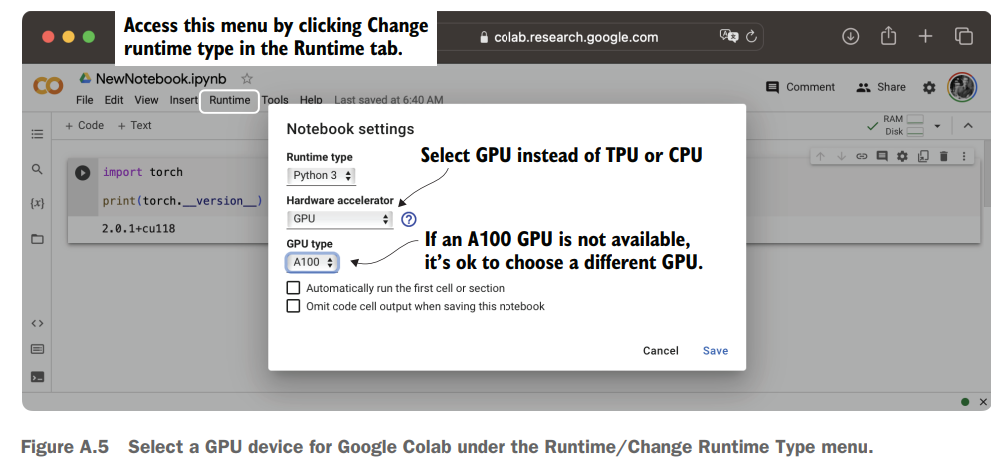

## Download the Image From Internet

`-P img`: This option specifies the target directory (img) to save the downloaded file.

In [11]:
!wget --no-check-certificate -P img https://eeweb.engineering.nyu.edu/~yao/EL5123/image/lena_color.tiff

--2025-01-27 18:30:44--  https://eeweb.engineering.nyu.edu/~yao/EL5123/image/lena_color.tiff
Resolving eeweb.engineering.nyu.edu (eeweb.engineering.nyu.edu)... 128.238.64.104
Connecting to eeweb.engineering.nyu.edu (eeweb.engineering.nyu.edu)|128.238.64.104|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 786572 (768K) [image/tiff]
Saving to: ‘img/lena_color.tiff.1’

lena_color.tiff.1   100%[===================>] 768.14K   585KB/s    in 1.3s    

2025-01-27 18:30:46 (585 KB/s) - ‘img/lena_color.tiff.1’ saved [786572/786572]



## Resize the image  ranging in size from `512×512` px to `8192×8192` px

In [12]:
import os
from PIL import Image

# Open the image file
image = Image.open("img/lena_color.tiff")

# Directory to save resized images
output_dir = "img/resized/"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Delete all files in the output directory
for file in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file)
    os.remove(file_path)

# Resize and save images with widths from 512 to 4960 in steps of 128
start_width = 512
end_width = 8192
step = 512

for new_width in range(start_width, end_width + 1, step):
    new_height = int((new_width / image.width) * image.height)
    resized_image = image.resize((new_width, new_height))
    # Format width with leading zeros if less than 1000
    formatted_width = f"{new_width:04}" if new_width < 1000 else f"{new_width}"
    output_path = os.path.join(output_dir, f"lena_color_{formatted_width}.tiff")
    resized_image.save(output_path)
    print(f"Saved resized image: {output_path}")

print("All images resized and saved successfully.")


Saved resized image: img/resized/lena_color_0512.tiff
Saved resized image: img/resized/lena_color_1024.tiff
Saved resized image: img/resized/lena_color_1536.tiff
Saved resized image: img/resized/lena_color_2048.tiff
Saved resized image: img/resized/lena_color_2560.tiff
Saved resized image: img/resized/lena_color_3072.tiff
Saved resized image: img/resized/lena_color_3584.tiff
Saved resized image: img/resized/lena_color_4096.tiff
Saved resized image: img/resized/lena_color_4608.tiff
Saved resized image: img/resized/lena_color_5120.tiff
Saved resized image: img/resized/lena_color_5632.tiff
Saved resized image: img/resized/lena_color_6144.tiff
Saved resized image: img/resized/lena_color_6656.tiff
Saved resized image: img/resized/lena_color_7168.tiff
Saved resized image: img/resized/lena_color_7680.tiff
Saved resized image: img/resized/lena_color_8192.tiff
All images resized and saved successfully.


## All the Encode and Decode Function

In [13]:
%%writefile encode_decode.cpp
#include <iostream>
#include <opencv2/opencv.hpp>
#include <vector>
#include <cmath>
#include <queue>
#include <unordered_map>
#include <algorithm>
#include <fstream>
#include <string>
#include <chrono>
#include <omp.h>
#include "kernel.cuh"

using namespace std;
using namespace cv;
using namespace std::chrono;

Mat readImage(const string &image_name)
{
    Mat image = imread(image_name);
    if (image.empty())
    {
        cerr << "Could not open or find the image" << endl;
        return Mat();
    }
    return image;
}

void ensureMultipleOf16(Mat &image)
{
    if (image.rows % 16 != 0 || image.cols % 16 != 0)
    {
        int newWidth = (image.cols / 16) * 16;
        int newHeight = (image.rows / 16) * 16;
        resize(image, image, Size(newWidth, newHeight), 0, 0, INTER_AREA);
    }
}

Mat RGB2YCbCr(const Mat &image)
{
    const array<double, 3> offset = {0.0, 128.0, 128.0};
    const double ycbcr_transform[3][3] = {
        {0.299, 0.587, 0.114},
        {-0.1687, -0.3313, 0.5},
        {0.5, -0.4187, -0.0813}};

    Mat ycbcr_image = Mat::zeros(image.size(), CV_8UC3);

    for (int i = 0; i < image.rows; ++i)
    {
        for (int j = 0; j < image.cols; ++j)
        {
            Vec3b pixel = image.at<Vec3b>(i, j);
            array<double, 3> transformed_pixel = {0.0, 0.0, 0.0};

            for (int k = 0; k < 3; ++k)
            {
                transformed_pixel[k] = offset[k];
                for (int l = 0; l < 3; ++l)
                {
                    transformed_pixel[k] += ycbcr_transform[k][l] * pixel[l];
                }
                transformed_pixel[k] = round(transformed_pixel[k]);
            }

            // Set the transformed Y, Cb, Cr values in the ycbcr_image
            ycbcr_image.at<Vec3b>(i, j) = Vec3b(
                static_cast<uchar>(transformed_pixel[0]),
                static_cast<uchar>(transformed_pixel[1]),
                static_cast<uchar>(transformed_pixel[2]));
        }
    }

    return ycbcr_image;
}

Mat YCbCr2RGB(const Mat &ycbcr_image)
{
    const array<double, 3> offset = {0.0, 128.0, 128.0};
    const double inverse_transform[3][3] = {
        {1.0, 0.0, 1.402},
        {1.0, -0.344136, -0.714136},
        {1.0, 1.772, 0.0}};

    Mat rgb_image = Mat::zeros(ycbcr_image.size(), CV_8UC3);

    for (int i = 0; i < ycbcr_image.rows; ++i)
    {
        for (int j = 0; j < ycbcr_image.cols; ++j)
        {
            Vec3b pixel = ycbcr_image.at<Vec3b>(i, j);
            array<double, 3> transformed_pixel = {0.0, 0.0, 0.0};

            for (int k = 0; k < 3; ++k)
            {
                transformed_pixel[k] = 0.0;
                for (int l = 0; l < 3; ++l)
                {
                    transformed_pixel[k] += inverse_transform[k][l] * (pixel[l] - offset[l]);
                }
                // Clamp the values to the 0-255 range
                transformed_pixel[k] = std::max(0.0, std::min(255.0, round(transformed_pixel[k])));
            }

            // Set the transformed R, G, B values in the rgb_image
            rgb_image.at<Vec3b>(i, j) = Vec3b(
                static_cast<uchar>(transformed_pixel[0]),
                static_cast<uchar>(transformed_pixel[1]),
                static_cast<uchar>(transformed_pixel[2]));
        }
    }

    return rgb_image;
}

// Function to perform chroma subsampling (4:2:0)
void chromaSubsampling(const Mat &input, Mat &Y, Mat &Cb, Mat &Cr)
{
    int width = input.cols;
    int height = input.rows;

    // Full resolution Y channel
    Y = Mat(height, width, CV_8UC1);
    // Quarter resolution Cb, Cr channels
    Cb = Mat(height / 2, width / 2, CV_8UC1);
    Cr = Mat(height / 2, width / 2, CV_8UC1);

    for (int i = 0; i < height; i += 2)
    {
        for (int j = 0; j < width; j += 2)
        {
            // Store full-res Y values
            Y.at<uchar>(i, j) = input.at<Vec3b>(i, j)[0];
            Y.at<uchar>(i + 1, j) = input.at<Vec3b>(i + 1, j)[0];
            Y.at<uchar>(i, j + 1) = input.at<Vec3b>(i, j + 1)[0];
            Y.at<uchar>(i + 1, j + 1) = input.at<Vec3b>(i + 1, j + 1)[0];

            // Store averaged Cb, Cr at quarter resolution
            Cb.at<uchar>(i / 2, j / 2) = (input.at<Vec3b>(i, j)[1] +
                                          input.at<Vec3b>(i + 1, j)[1] +
                                          input.at<Vec3b>(i, j + 1)[1] +
                                          input.at<Vec3b>(i + 1, j + 1)[1]) /
                                         4;

            Cr.at<uchar>(i / 2, j / 2) = (input.at<Vec3b>(i, j)[2] +
                                          input.at<Vec3b>(i + 1, j)[2] +
                                          input.at<Vec3b>(i, j + 1)[2] +
                                          input.at<Vec3b>(i + 1, j + 1)[2]) /
                                         4;
        }
    }
}

void upsampleChroma(const Mat &Cb, const Mat &Cr, Mat &outputCb, Mat &outputCr, int width, int height)
{
    // Upsample Cb and Cr to full resolution (same size as Y channel)
    outputCb = Mat(height, width, CV_8UC1);
    outputCr = Mat(height, width, CV_8UC1);

    for (int i = 0; i < height; i++)
    {
        for (int j = 0; j < width; j++)
        {
            // For each pixel, interpolate the Cb and Cr values
            int x = j / 2;
            int y = i / 2;

            // Bilinear interpolation or simple replication
            outputCb.at<uchar>(i, j) = Cb.at<uchar>(y, x); // You can replace with interpolation logic here
            outputCr.at<uchar>(i, j) = Cr.at<uchar>(y, x); // Same for Cr
        }
    }
}

struct CompressionStats
{
    size_t original_size;        // Original image size (in bytes)
    size_t compressed_size;      // Compressed image size (in bytes)
    double compression_ratio;    // Compression ratio (original / compressed)
    double percentage_reduction; // Percentage reduction in size
    double original_size_kb;     // Original size in KB
    double compressed_size_kb;   // Compressed size in KB
};

CompressionStats calculateCompressionStats(const string &original_filename, const string &compressed_filename)
{
    CompressionStats stats;

    // Read the image using OpenCV
    cv::Mat image = cv::imread(original_filename, cv::IMREAD_COLOR); // Load in RGB format
    if (image.empty())
    {
        throw std::runtime_error("Cannot open the image file: " + original_filename);
    }

    // Calculate uncompressed size (width * height * 3 bytes per pixel)
    int width = image.cols;
    int height = image.rows;
    int channels = image.channels();
    stats.original_size = static_cast<size_t>(width * height * channels);

    // Convert uncompressed size to KB
    stats.original_size_kb = static_cast<double>(stats.original_size) / 1024.0;

    // Open the compressed file and calculate its size
    ifstream file(compressed_filename, ios::binary | ios::ate); // Open file and move to the end
    if (!file)
    {
        throw runtime_error("Cannot open the compressed file: " + compressed_filename);
    }

    stats.compressed_size = file.tellg(); // Get the size of the compressed file

    // Convert compressed size to KB
    stats.compressed_size_kb = static_cast<double>(stats.compressed_size) / 1024.0;

    // Calculate compression ratio
    if (stats.compressed_size == 0)
    {
        stats.compression_ratio = 0;
        stats.percentage_reduction = 0;
    }
    else
    {
        stats.compression_ratio = static_cast<double>(stats.original_size) / stats.compressed_size;
        stats.percentage_reduction = (1.0 - static_cast<double>(stats.compressed_size) / stats.original_size) * 100;
    }

    file.close();
    return stats;
}

void extractBlocks(const Mat &Y, vector<vector<vector<int>>> &blocks)
{
    int height = Y.rows;
    int width = Y.cols;

    for (int i = 0; i < height; i += 8)
    {
        for (int j = 0; j < width; j += 8)
        {
            vector<vector<int>> block(8, vector<int>(8, 0));

            for (int x = 0; x < 8; ++x)
            {
                for (int y = 0; y < 8; ++y)
                {
                    if (i + x < height && j + y < width)
                    {
                        block[x][y] = Y.at<uchar>(i + x, j + y);
                    }
                }
            }

            blocks.push_back(block);
        }
    }
}

void dct(const vector<vector<int>> &image_block, vector<vector<float>> &dct_block)
{
    // Iterate over each coefficient in the 8x8 DCT matrix
    for (int u = 0; u < 8; u++)
    {
        for (int v = 0; v < 8; v++)
        {
            float cu = (u == 0) ? 1 / sqrt(2) : 1.0;
            float cv = (v == 0) ? 1 / sqrt(2) : 1.0;

            float sum_val = 0;

            // Perform the summation of the DCT formula
            for (int x = 0; x < 8; x++)
            {
                for (int y = 0; y < 8; y++)
                {
                    sum_val += image_block[x][y] *
                               cos((2 * x + 1) * u * M_PI / 16) *
                               cos((2 * y + 1) * v * M_PI / 16);
                }
            }

            // 100 / 100 because of round to 2 decimal places
            dct_block[u][v] = round(0.25 * cu * cv * sum_val * 100) / 100;
        }
    }
}

void recenterAroundZero(vector<vector<int>> &mat)
{
    for (auto &row : mat)
    {
        for (auto &val : row)
        {
            val -= 128;
        }
    }
}

void quantize(vector<vector<float>> &dct_block, const vector<vector<int>> &quantization_table)
{
    for (int i = 0; i < 8; i++)
    {
        for (int j = 0; j < 8; j++)
        {
            float quantized_value = round(dct_block[i][j] / quantization_table[i][j]);
            dct_block[i][j] = (quantized_value == -0.0f) ? 0.0f : quantized_value;
        }
    }
}

void zigzag_scan(const vector<vector<float>> &block, vector<int> &zigzag)
{
    zigzag.clear();     // Clear the vector to ensure it's empty
    zigzag.reserve(64); // Reserve space for 64 elements

    for (int i = 0; i < 15; i++)
    {
        if (i < 8)
        {
            for (int j = 0; j <= i; j++)
            {
                if (i % 2 == 0)
                {
                    zigzag.push_back(static_cast<int>(block[i - j][j]));
                }
                else
                {
                    zigzag.push_back(static_cast<int>(block[j][i - j]));
                }
            }
        }
        else
        {
            for (int j = 0; j < 15 - i; j++)
            {
                if (i % 2 == 0)
                {
                    zigzag.push_back(static_cast<int>(block[7 - j][j + (i - 7)]));
                }
                else
                {
                    zigzag.push_back(static_cast<int>(block[j + (i - 7)][7 - j]));
                }
            }
        }
    }
}

vector<int> run_length_encode(const vector<int> &ac_coefficients)
{
    vector<int> rle_encoded_ac;
    int run_length = 1;
    int prev_chr = ac_coefficients[0];
    for (size_t i = 1; i < ac_coefficients.size(); ++i)
    {
        if (ac_coefficients[i] == prev_chr)
        {
            run_length++;
        }
        else
        {
            rle_encoded_ac.push_back(prev_chr);
            rle_encoded_ac.push_back(run_length);
            prev_chr = ac_coefficients[i];
            run_length = 1;
        }
    }
    // Add the last entry
    rle_encoded_ac.push_back(prev_chr);
    rle_encoded_ac.push_back(run_length);
    return rle_encoded_ac;
}

unordered_map<int, int> build_frequency_dict(const vector<int> &data)
{
    unordered_map<int, int> frequency_dict;
    for (int val : data)
    {
        frequency_dict[val]++;
    }
    return frequency_dict;
}

struct HuffmanNode
{
    int value;
    int frequency;
    HuffmanNode *left;
    HuffmanNode *right;

    HuffmanNode(int val, int freq) : value(val), frequency(freq), left(nullptr), right(nullptr) {}
};

struct Compare
{
    bool operator()(HuffmanNode *left, HuffmanNode *right)
    {
        return left->frequency > right->frequency;
    }
};

HuffmanNode *build_huffman_tree(const unordered_map<int, int> &freq_dict)
{
    // Convert unordered_map to vector of pairs
    vector<pair<int, int>> freq_vector(freq_dict.begin(), freq_dict.end());

    // Sort by frequency, breaking ties by key (ascending order)
    sort(freq_vector.begin(), freq_vector.end(), [](const pair<int, int> &a, const pair<int, int> &b)
         {
             if (a.second == b.second)
                 return a.first < b.first; // Break ties by key
             return a.second < b.second;   // Sort by frequency
         });

    // Create a priority queue (min-heap) and populate it with sorted elements
    priority_queue<HuffmanNode *, vector<HuffmanNode *>, Compare> min_heap;
    for (const auto &pair : freq_vector)
    {
        min_heap.push(new HuffmanNode(pair.first, pair.second));
    }

    // Build the Huffman tree
    while (min_heap.size() > 1)
    {
        HuffmanNode *left = min_heap.top();
        min_heap.pop();
        HuffmanNode *right = min_heap.top();
        min_heap.pop();

        // Create an internal node with combined frequency
        HuffmanNode *internal = new HuffmanNode(99999, left->frequency + right->frequency);
        internal->left = left;
        internal->right = right;

        // Push the internal node back into the priority queue
        min_heap.push(internal);
    }

    // Return the root of the Huffman tree
    return min_heap.top();
}

void generate_huffman_codes(HuffmanNode *node, const string &code, unordered_map<int, string> &huffman_codes)
{
    if (!node)
        return;

    if (node->value != 99999)
    {
        huffman_codes[node->value] = code;
    }

    generate_huffman_codes(node->left, code + "0", huffman_codes);
    generate_huffman_codes(node->right, code + "1", huffman_codes);
}

string huffman_encode(const vector<int> &data, const unordered_map<int, string> &huffman_codes)
{
    string encoded_str;
    for (int val : data)
    {
        encoded_str += huffman_codes.at(val);
    }
    return encoded_str;
}

vector<int> huffman_decode(const string &encoded_str, HuffmanNode *root)
{
    vector<int> decoded_values;
    HuffmanNode *current = root;
    for (char bit : encoded_str)
    {
        current = (bit == '0') ? current->left : current->right;
        if (!current->left && !current->right)
        {
            decoded_values.push_back(current->value);
            current = root;
        }
    }
    return decoded_values;
}

vector<vector<int>> decodeRLE(const vector<int> &rle_encoded)
{
    vector<vector<int>> blocks;
    vector<int> current_block;
    int current_length = 0;

    for (size_t i = 0; i < rle_encoded.size(); i += 2)
    {
        int value = rle_encoded[i];         // Value at odd index
        int frequency = rle_encoded[i + 1]; // Frequency at even index

        // Add "frequency" occurrences of "value" to the current block
        for (int j = 0; j < frequency; ++j)
        {
            current_block.push_back(value);
            ++current_length;

            // If the block size reaches 64, save it and start a new block
            if (current_length == 64)
            {
                blocks.push_back(current_block);
                current_block.clear();
                current_length = 0;
            }
        }
    }

    // If there is remaining data in the current block, add it to blocks
    if (!current_block.empty())
    {
        blocks.push_back(current_block);
    }

    return blocks;
}

void inverse_zigzag(const vector<int> &zigzag, vector<vector<float>> &block)
{
    block.assign(8, vector<float>(8, 0.0)); // Initialize the 8x8 block with zeros
    int index = 0;

    for (int i = 0; i < 15; i++)
    {
        if (i < 8)
        {
            for (int j = 0; j <= i; j++)
            {
                if (i % 2 == 0)
                {
                    block[i - j][j] = zigzag[index++];
                }
                else
                {
                    block[j][i - j] = zigzag[index++];
                }
            }
        }
        else
        {
            for (int j = 0; j < 15 - i; j++)
            {
                if (i % 2 == 0)
                {
                    block[7 - j][j + (i - 7)] = zigzag[index++];
                }
                else
                {
                    block[j + (i - 7)][7 - j] = zigzag[index++];
                }
            }
        }
    }
}

void inverse_quantize(vector<vector<float>> &dct_block, const vector<vector<int>> &quantization_table)
{
    for (int i = 0; i < 8; i++)
    {
        for (int j = 0; j < 8; j++)
        {
            dct_block[i][j] *= quantization_table[i][j];
        }
    }
}

void idct(const vector<vector<float>> &dct_block, vector<vector<int>> &image_block)
{
    for (int x = 0; x < 8; x++)
    {
        for (int y = 0; y < 8; y++)
        {
            float sum_val = 0.0;

            for (int u = 0; u < 8; u++)
            {
                for (int v = 0; v < 8; v++)
                {
                    float cu = (u == 0) ? 1 / sqrt(2) : 1.0;
                    float cv = (v == 0) ? 1 / sqrt(2) : 1.0;

                    sum_val += cu * cv * dct_block[u][v] *
                               cos((2 * x + 1) * u * M_PI / 16) *
                               cos((2 * y + 1) * v * M_PI / 16);
                }
            }

            // Scale by 1/4 and round to the nearest integer
            image_block[x][y] = round(0.25 * sum_val);
        }
    }
}

void add_back_128(vector<vector<int>> &image_block)
{
    for (auto &row : image_block)
    {
        for (auto &val : row)
        {
            val += 128;
        }
    }
}

struct EncodedData
{
    string huffman_encoded_str;
    unordered_map<int, int> freq_dict;
};

EncodedData encodeChannel(const Mat &channel, const vector<vector<int>> &quantization_table)
{
    // Extract 8x8 blocks
    vector<vector<vector<int>>> blocks;
    extractBlocks(channel, blocks);

    // Vector to store encoded values for all blocks
    vector<int> combined_encoded_values;

    // Process each block
    for (auto &block : blocks)
    {
        // Recenter around zero
        recenterAroundZero(block);

        // Perform DCT
        vector<vector<float>> dct_block(8, vector<float>(8, 0.0));
        dct(block, dct_block);

        // Quantization
        quantize(dct_block, quantization_table);

        // Zigzag scan
        vector<int> zigzag;
        zigzag_scan(dct_block, zigzag);

        // Run-length encoding
        vector<int> rle_encoded = run_length_encode(zigzag);

        // Add encoded values to combined vector
        combined_encoded_values.insert(combined_encoded_values.end(),
                                       rle_encoded.begin(),
                                       rle_encoded.end());
    }

    // Build Huffman tree and codes
    unordered_map<int, int> freq_dict = build_frequency_dict(combined_encoded_values);
    HuffmanNode *huffman_tree = build_huffman_tree(freq_dict);

    unordered_map<int, string> huffman_codes;
    generate_huffman_codes(huffman_tree, "", huffman_codes);

    // Perform Huffman encoding
    string huffman_encoded_str = huffman_encode(combined_encoded_values, huffman_codes);

    return {huffman_encoded_str, freq_dict};
}

Mat decodeChannel(const string &encoded_data, int height, int width, const vector<vector<int>> &quantization_table, const unordered_map<int, int> &freq_dict)
{
    // Rebuild Huffman tree from frequency dictionary
    HuffmanNode *huffman_tree = build_huffman_tree(freq_dict);

    // Huffman decode
    vector<int> decoded_values = huffman_decode(encoded_data, huffman_tree);

    // RLE decode
    vector<vector<int>> decoded_blocks = decodeRLE(decoded_values);

    // Create vector of restored blocks
    vector<vector<vector<float>>>
        restored_blocks(decoded_blocks.size(),
                        vector<vector<float>>(8, vector<float>(8, 0.0)));
    vector<vector<vector<int>>>
        reconstructed_blocks(decoded_blocks.size(),
                             vector<vector<int>>(8, vector<int>(8, 0)));

    // Process each block
    for (size_t i = 0; i < decoded_blocks.size(); i++)
    {
        inverse_zigzag(decoded_blocks[i], restored_blocks[i]);
        inverse_quantize(restored_blocks[i], quantization_table);
        idct(restored_blocks[i], reconstructed_blocks[i]);
        add_back_128(reconstructed_blocks[i]);
    }

    // Create output matrix
    Mat reconstructed = Mat::zeros(height, width, CV_8UC1);

    // Copy blocks to reconstructed matrix
    int block_row = 0, block_col = 0;
    for (const auto &block : reconstructed_blocks)
    {
        for (int i = 0; i < 8; i++)
        {
            for (int j = 0; j < 8; j++)
            {
                int pixel_row = block_row * 8 + i;
                int pixel_col = block_col * 8 + j;
                if (pixel_row < height && pixel_col < width)
                {
                    reconstructed.at<uchar>(pixel_row, pixel_col) =
                        static_cast<uchar>(std::clamp(block[i][j], 0, 255));
                }
            }
        }
        block_col++;
        if (block_col * 8 >= width)
        {
            block_col = 0;
            block_row++;
        }
    }

    return reconstructed;
}

EncodedData encodeChannelGPU(const Mat &channel, const vector<vector<int>> &quantization_table)
{
    // Extract 8x8 blocks
    vector<vector<vector<int>>> blocks;
    extractBlocks(channel, blocks);

    // Running the DCT and quantization in parallel (64 threads per block)
    vector<vector<float>> quantize_coefficients;
    dctQuantizationParallel(blocks, quantization_table, quantize_coefficients);

    vector<int> combined_encoded_values;
    for (auto &block : quantize_coefficients)
    {
        // Perform Zigzag
        vector<int> zigzag;
        vector<vector<float>> wrapped_block(8, vector<float>(8, 0.0));
        for (int i = 0; i < 8; ++i)
        {
            for (int j = 0; j < 8; ++j)
            {
                wrapped_block[i][j] = block[i * 8 + j];
            }
        }
        zigzag_scan(wrapped_block, zigzag);

        // Perform Run-length encoding
        vector<int> rle_encoded = run_length_encode(zigzag);

        combined_encoded_values.insert(combined_encoded_values.end(),
                                       rle_encoded.begin(),
                                       rle_encoded.end());
    }

    // Build Huffman tree and codes
    unordered_map<int, int>
        freq_dict = build_frequency_dict(combined_encoded_values);
    HuffmanNode *huffman_tree = build_huffman_tree(freq_dict);

    unordered_map<int, string> huffman_codes;
    generate_huffman_codes(huffman_tree, "", huffman_codes);

    // Perform Huffman encoding
    string huffman_encoded_str = huffman_encode(combined_encoded_values, huffman_codes);

    return {huffman_encoded_str, freq_dict};
}

Mat decodeChannelGPU(const string &encoded_data, int height, int width, const vector<vector<int>> &quantization_table, const unordered_map<int, int> &freq_dict)
{
    // Rebuild Huffman tree from frequency dictionary
    HuffmanNode *huffman_tree = build_huffman_tree(freq_dict);

    // Huffman decode
    vector<int> decoded_values = huffman_decode(encoded_data, huffman_tree);

    // RLE decode
    vector<vector<int>> decoded_blocks = decodeRLE(decoded_values);

    // Create vector of restored blocks
    vector<vector<vector<float>>>
        restored_blocks(decoded_blocks.size(),
                        vector<vector<float>>(8, vector<float>(8, 0.0)));

    // Process each block
    for (size_t i = 0; i < decoded_blocks.size(); i++)
    {
        inverse_zigzag(decoded_blocks[i], restored_blocks[i]);
    }

    vector<vector<vector<int>>> image_blocks;
    dequantizeInverseDCTParallel(restored_blocks, quantization_table, image_blocks);

    // Create output matrix
    Mat reconstructed = Mat::zeros(height, width, CV_8UC1);

    // Copy blocks to reconstructed matrix
    int block_row = 0, block_col = 0;
    for (const auto &block : image_blocks)
    {
        for (int i = 0; i < 8; i++)
        {
            for (int j = 0; j < 8; j++)
            {
                int pixel_row = block_row * 8 + i;
                int pixel_col = block_col * 8 + j;
                if (pixel_row < height && pixel_col < width)
                {
                    reconstructed.at<uchar>(pixel_row, pixel_col) =
                        static_cast<uchar>(std::clamp(block[i][j], 0, 255));
                }
            }
        }
        block_col++;
        if (block_col * 8 >= width)
        {
            block_col = 0;
            block_row++;
        }
    }

    return reconstructed;
}

void initDCTTableOMP(vector<vector<float>> &dct_table)
{
    dct_table.resize(8, vector<float>(8, 0.0f));
    for (int i = 0; i < 8; i++)
    {
        float ci = (i == 0) ? 1.0f / sqrt(2.0f) : 1.0f;
        for (int j = 0; j < 8; j++)
        {
            dct_table[i][j] = ci * cos((2.0 * j + 1.0) * i * M_PI / 16.0);
        }
    }
}

// Recentering around zero
void recentreAroundZeroOMP(vector<vector<int>> &block)
{
    for (int i = 0; i < 8; ++i)
    {
        for (int j = 0; j < 8; ++j)
        {
            block[i][j] -= 128;
        }
    }
}

// Perform 2D DCT on a block
void performDCTOMP(const vector<vector<int>> &block, vector<vector<float>> &dct_block, const vector<vector<float>> &dct_table)
{
    dct_block.resize(8, vector<float>(8, 0.0f));

    // Row-wise DCT
    vector<vector<float>> temp_block(8, vector<float>(8, 0.0f));
    for (int u = 0; u < 8; ++u)
    {
        for (int v = 0; v < 8; ++v)
        {
            float sum = 0.0f;
            for (int x = 0; x < 8; ++x)
            {
                sum += block[u][x] * dct_table[v][x];
            }
            temp_block[u][v] = sum;
        }
    }

    // Column-wise DCT
    for (int u = 0; u < 8; ++u)
    {
        for (int v = 0; v < 8; ++v)
        {
            float sum = 0.0f;
            for (int x = 0; x < 8; ++x)
            {
                sum += temp_block[x][v] * dct_table[u][x];
            }
            dct_block[u][v] = roundf(sum / 4.0f * 100) / 100;
        }
    }
}

// Perform quantization
void quantizeBlockOMP(vector<vector<float>> &dct_block, const vector<vector<int>> &quantization_table)
{
    for (int i = 0; i < 8; ++i)
    {
        for (int j = 0; j < 8; ++j)
        {
            dct_block[i][j] = roundf(dct_block[i][j] / quantization_table[i][j]);
        }
    }
}

EncodedData encodeChannelOMP(const Mat &channel, const vector<vector<int>> &quantization_table)
{
    // Extract 8x8 blocks
    vector<vector<vector<int>>> blocks;
    extractBlocks(channel, blocks);

    // Initialize DCT table
    vector<vector<float>> dct_table;
    initDCTTableOMP(dct_table);

    vector<vector<float>> quantize_coefficients(blocks.size());

    // Parallel DCT and Quantization using OpenMP
    omp_set_num_threads(2);
    // int max_threads = omp_get_max_threads();
    // std::cout << "Maximum threads: " << max_threads << std::endl;
#pragma omp parallel for
    for (int b = 0; b < blocks.size(); ++b)
    {
        // Recentering around zero
        recentreAroundZeroOMP(blocks[b]);

        vector<vector<float>> dct_block;
        performDCTOMP(blocks[b], dct_block, dct_table);
        quantizeBlockOMP(dct_block, quantization_table);

        // Flatten the quantized coefficients
        quantize_coefficients[b].resize(64);
        for (int i = 0; i < 8; ++i)
        {
            for (int j = 0; j < 8; ++j)
            {
                quantize_coefficients[b][i * 8 + j] = dct_block[i][j];
            }
        }
    }

    vector<int> combined_encoded_values;
    for (auto &block : quantize_coefficients)
    {
        // Perform Zigzag
        vector<int> zigzag;
        vector<vector<float>> wrapped_block(8, vector<float>(8, 0.0f));
        for (int i = 0; i < 8; ++i)
        {
            for (int j = 0; j < 8; ++j)
            {
                wrapped_block[i][j] = block[i * 8 + j];
            }
        }
        zigzag_scan(wrapped_block, zigzag);

        // Perform Run-length encoding
        vector<int> rle_encoded = run_length_encode(zigzag);

        combined_encoded_values.insert(combined_encoded_values.end(),
                                       rle_encoded.begin(),
                                       rle_encoded.end());
    }
    // After parallel section
    for (auto &block : quantize_coefficients)
    {
        block.clear(); // Release memory
    }

    // Build Huffman tree and codes
    unordered_map<int, int> freq_dict = build_frequency_dict(combined_encoded_values);
    HuffmanNode *huffman_tree = build_huffman_tree(freq_dict);

    unordered_map<int, string> huffman_codes;
    generate_huffman_codes(huffman_tree, "", huffman_codes);

    // Perform Huffman encoding
    string huffman_encoded_str = huffman_encode(combined_encoded_values, huffman_codes);

    return {huffman_encoded_str, freq_dict};
}

void inverseDCTOMP(const vector<vector<float>> &input, vector<vector<int>> &output)
{
    output.resize(8, vector<int>(8, 0));

    vector<vector<float>> temp(8, vector<float>(8, 0.0f));

    // // Row-wise inverse DCT
    // #pragma omp parallel for collapse(2)
    for (int i = 0; i < 8; ++i)
    {
        for (int j = 0; j < 8; ++j)
        {
            float sum = 0.0f;
            for (int k = 0; k < 8; ++k)
            {
                float ck = (k == 0) ? 1.0f / sqrt(2.0f) : 1.0f;
                sum += ck * input[i][k] * cos((2.0f * j + 1.0f) * k * M_PI / 16.0f);
            }
            temp[i][j] = sum;
        }
    }

    // // Column-wise inverse DCT
    // #pragma omp parallel for collapse(2)
    for (int i = 0; i < 8; ++i)
    {
        for (int j = 0; j < 8; ++j)
        {
            float sum = 0.0f;
            for (int k = 0; k < 8; ++k)
            {
                float ck = (k == 0) ? 1.0f / sqrt(2.0f) : 1.0f;
                sum += ck * temp[k][j] * cos((2.0f * i + 1.0f) * k * M_PI / 16.0f);
            }
            output[i][j] = static_cast<int>(round(sum / 4.0f)) + 128;
        }
    }
}

void dequantizeInverseDCTOMP(const vector<vector<vector<float>>> &quantize_coefficients,
                             const vector<vector<int>> &quantization_table,
                             vector<vector<vector<int>>> &output_blocks)
{
    int num_blocks = quantize_coefficients.size();
    output_blocks.resize(num_blocks, vector<vector<int>>(8, vector<int>(8)));
    omp_set_num_threads(2);
#pragma omp parallel for
    for (int b = 0; b < num_blocks; ++b)
    {
        // Dequantize the block
        vector<vector<float>> dequantized_block(8, vector<float>(8, 0.0f));
        for (int i = 0; i < 8; ++i)
        {
            for (int j = 0; j < 8; ++j)
            {
                dequantized_block[i][j] = quantize_coefficients[b][i][j] * quantization_table[i][j];
            }
        }

        // Perform Inverse DCT
        inverseDCTOMP(dequantized_block, output_blocks[b]);
    }
}

Mat decodeChannelOMP(const string &encoded_data, int height, int width,
                     const vector<vector<int>> &quantization_table, const unordered_map<int, int> &freq_dict)
{
    // Rebuild Huffman tree from frequency dictionary
    HuffmanNode *huffman_tree = build_huffman_tree(freq_dict);

    // Huffman decode
    vector<int> decoded_values = huffman_decode(encoded_data, huffman_tree);

    // RLE decode
    vector<vector<int>> decoded_blocks = decodeRLE(decoded_values);

    // Create vector of restored blocks
    vector<vector<vector<float>>> restored_blocks(decoded_blocks.size(), vector<vector<float>>(8, vector<float>(8, 0.0)));

    // Process each block
    for (size_t i = 0; i < decoded_blocks.size(); ++i)
    {
        inverse_zigzag(decoded_blocks[i], restored_blocks[i]);
    }

    vector<vector<vector<int>>> image_blocks;
    dequantizeInverseDCTOMP(restored_blocks, quantization_table, image_blocks);

    // Create output matrix
    Mat reconstructed = Mat::zeros(height, width, CV_8UC1);

    // Copy blocks to reconstructed matrix
    int block_row = 0, block_col = 0;
    for (const auto &block : image_blocks)
    {
        for (int i = 0; i < 8; ++i)
        {
            for (int j = 0; j < 8; ++j)
            {
                int pixel_row = block_row * 8 + i;
                int pixel_col = block_col * 8 + j;
                if (pixel_row < height && pixel_col < width)
                {
                    reconstructed.at<uchar>(pixel_row, pixel_col) =
                        static_cast<uchar>(std::clamp(block[i][j], 0, 255));
                }
            }
        }
        block_col++;
        if (block_col * 8 >= width)
        {
            block_col = 0;
            block_row++;
        }
    }

    return reconstructed;
}

// Function to convert a Huffman-encoded string to a bitstream (vector of bytes)
vector<unsigned char> stringToBitstream(const string &huffman_data)
{
    vector<unsigned char> bitstream;
    unsigned char current_byte = 0;
    int bit_pos = 0;

    for (char bit : huffman_data)
    {
        // Set the corresponding bit in the current byte
        if (bit == '1')
        {
            current_byte |= (1 << (7 - bit_pos)); // Set bit to 1
        }
        // Else bit is '0', no action needed since the bit is already 0

        // Move to the next bit in the current byte
        bit_pos++;

        // If the current byte is full (8 bits), add it to the bitstream
        if (bit_pos == 8)
        {
            bitstream.push_back(current_byte);
            current_byte = 0; // Reset current byte
            bit_pos = 0;      // Reset bit position
        }
    }

    // If there are leftover bits in the current byte, push it to the bitstream
    if (bit_pos > 0)
    {
        bitstream.push_back(current_byte);
    }

    return bitstream;
}

// Function to convert a bitstream (vector of bytes) back to a Huffman-encoded string
string bitstreamToString(const vector<unsigned char> &bitstream, int total_bits)
{
    string huffman_data;
    int bit_count = 0;

    for (unsigned char byte : bitstream)
    {
        for (int i = 7; i >= 0; --i)
        {
            if (bit_count == total_bits)
                return huffman_data; // Stop when we've processed all bits

            huffman_data.push_back((byte & (1 << i)) ? '1' : '0');
            ++bit_count;
        }
    }

    return huffman_data; // Return the reconstructed Huffman string
}

void saveEncodedData(const string &filename,
                     const string &y_data, const string &cb_data, const string &cr_data,
                     int y_rows, int y_cols, int cb_rows, int cb_cols, int cr_rows, int cr_cols,
                     const unordered_map<int, int> &y_freq_dict, const unordered_map<int, int> &cb_freq_dict, const unordered_map<int, int> &cr_freq_dict)
{
    ofstream file(filename, ios::binary);
    if (!file)
    {
        throw runtime_error("Cannot open file for writing: " + filename);
    }

    // Write dimensions
    file.write(reinterpret_cast<const char *>(&y_rows), sizeof(int));
    file.write(reinterpret_cast<const char *>(&y_cols), sizeof(int));
    file.write(reinterpret_cast<const char *>(&cb_rows), sizeof(int));
    file.write(reinterpret_cast<const char *>(&cb_cols), sizeof(int));
    file.write(reinterpret_cast<const char *>(&cr_rows), sizeof(int));
    file.write(reinterpret_cast<const char *>(&cr_cols), sizeof(int));

    if (file.fail())
        throw runtime_error("Error writing dimensions.");

    // Write bitstreams
    vector<unsigned char> y_bitstream = stringToBitstream(y_data);
    vector<unsigned char> cb_bitstream = stringToBitstream(cb_data);
    vector<unsigned char> cr_bitstream = stringToBitstream(cr_data);

    int y_len = y_bitstream.size();
    int cb_len = cb_bitstream.size();
    int cr_len = cr_bitstream.size();

    file.write(reinterpret_cast<const char *>(&y_len), sizeof(int));
    file.write(reinterpret_cast<const char *>(&cb_len), sizeof(int));
    file.write(reinterpret_cast<const char *>(&cr_len), sizeof(int));

    file.write(reinterpret_cast<const char *>(y_bitstream.data()), y_len);
    file.write(reinterpret_cast<const char *>(cb_bitstream.data()), cb_len);
    file.write(reinterpret_cast<const char *>(cr_bitstream.data()), cr_len);

    if (file.fail())
        throw runtime_error("Error writing bitstreams.");

    // Write frequency dictionaries
    int y_dict_size = y_freq_dict.size();
    int cb_dict_size = cb_freq_dict.size();
    int cr_dict_size = cr_freq_dict.size();

    file.write(reinterpret_cast<const char *>(&y_dict_size), sizeof(int));
    file.write(reinterpret_cast<const char *>(&cb_dict_size), sizeof(int));
    file.write(reinterpret_cast<const char *>(&cr_dict_size), sizeof(int));

    for (const auto &pair : y_freq_dict)
    {
        file.write(reinterpret_cast<const char *>(&pair.first), sizeof(int));
        file.write(reinterpret_cast<const char *>(&pair.second), sizeof(int));
    }

    for (const auto &pair : cb_freq_dict)
    {
        file.write(reinterpret_cast<const char *>(&pair.first), sizeof(int));
        file.write(reinterpret_cast<const char *>(&pair.second), sizeof(int));
    }

    for (const auto &pair : cr_freq_dict)
    {
        file.write(reinterpret_cast<const char *>(&pair.first), sizeof(int));
        file.write(reinterpret_cast<const char *>(&pair.second), sizeof(int));
    }

    if (file.fail())
        throw runtime_error("Error writing frequency dictionaries.");

    file.close();
}

void loadEncodedData(const string &filename,
                     string &y_data, string &cb_data, string &cr_data,
                     int &y_rows, int &y_cols, int &cb_rows, int &cb_cols, int &cr_rows, int &cr_cols,
                     unordered_map<int, int> &y_freq_dict, unordered_map<int, int> &cb_freq_dict, unordered_map<int, int> &cr_freq_dict)
{
    ifstream file(filename, ios::binary);
    if (!file)
    {
        throw runtime_error("Cannot open file for reading: " + filename);
    }

    // Read dimensions
    file.read(reinterpret_cast<char *>(&y_rows), sizeof(int));
    file.read(reinterpret_cast<char *>(&y_cols), sizeof(int));
    file.read(reinterpret_cast<char *>(&cb_rows), sizeof(int));
    file.read(reinterpret_cast<char *>(&cb_cols), sizeof(int));
    file.read(reinterpret_cast<char *>(&cr_rows), sizeof(int));
    file.read(reinterpret_cast<char *>(&cr_cols), sizeof(int));

    if (file.fail())
        throw runtime_error("Error reading dimensions.");

    // Read bitstreams
    int y_len, cb_len, cr_len;
    file.read(reinterpret_cast<char *>(&y_len), sizeof(int));
    file.read(reinterpret_cast<char *>(&cb_len), sizeof(int));
    file.read(reinterpret_cast<char *>(&cr_len), sizeof(int));

    vector<unsigned char> y_bitstream(y_len), cb_bitstream(cb_len), cr_bitstream(cr_len);
    file.read(reinterpret_cast<char *>(y_bitstream.data()), y_len);
    file.read(reinterpret_cast<char *>(cb_bitstream.data()), cb_len);
    file.read(reinterpret_cast<char *>(cr_bitstream.data()), cr_len);

    if (file.fail())
        throw runtime_error("Error reading bitstreams.");

    y_data = bitstreamToString(y_bitstream, y_len * 8);
    cb_data = bitstreamToString(cb_bitstream, cb_len * 8);
    cr_data = bitstreamToString(cr_bitstream, cr_len * 8);

    // Read frequency dictionaries
    int y_dict_size, cb_dict_size, cr_dict_size;
    file.read(reinterpret_cast<char *>(&y_dict_size), sizeof(int));
    file.read(reinterpret_cast<char *>(&cb_dict_size), sizeof(int));
    file.read(reinterpret_cast<char *>(&cr_dict_size), sizeof(int));

    if (file.fail())
        throw runtime_error("Error reading dictionary sizes.");

    for (int i = 0; i < y_dict_size; ++i)
    {
        int key, value;
        file.read(reinterpret_cast<char *>(&key), sizeof(int));
        file.read(reinterpret_cast<char *>(&value), sizeof(int));
        y_freq_dict[key] = value;
    }

    for (int i = 0; i < cb_dict_size; ++i)
    {
        int key, value;
        file.read(reinterpret_cast<char *>(&key), sizeof(int));
        file.read(reinterpret_cast<char *>(&value), sizeof(int));
        cb_freq_dict[key] = value;
    }

    for (int i = 0; i < cr_dict_size; ++i)
    {
        int key, value;
        file.read(reinterpret_cast<char *>(&key), sizeof(int));
        file.read(reinterpret_cast<char *>(&value), sizeof(int));
        cr_freq_dict[key] = value;
    }

    if (file.fail())
        throw runtime_error("Error reading frequency dictionaries.");

    file.close();
}

double mainEncode(const Mat &Y, const Mat &Cb, const Mat &Cr,
                  const vector<vector<int>> &quantization_table_Y,
                  const vector<vector<int>> &quantization_table_CbCr,
                  EncodedData &y_encoded, EncodedData &cb_encoded, EncodedData &cr_encoded, string platform)
{
    // Measure the start of encoding time
    auto start_encoding = high_resolution_clock::now();

    // Encode each channel
    if (platform == "CPU")
    {
        y_encoded = encodeChannel(Y, quantization_table_Y);
        cb_encoded = encodeChannel(Cb, quantization_table_CbCr);
        cr_encoded = encodeChannel(Cr, quantization_table_CbCr);
    }
    else if (platform == "OMP")
    {
        y_encoded = encodeChannelOMP(Y, quantization_table_Y);
        cb_encoded = encodeChannelOMP(Cb, quantization_table_CbCr);
        cr_encoded = encodeChannelOMP(Cr, quantization_table_CbCr);
    }
    else
    {
        y_encoded = encodeChannelGPU(Y, quantization_table_Y);
        cb_encoded = encodeChannelGPU(Cb, quantization_table_CbCr);
        cr_encoded = encodeChannelGPU(Cr, quantization_table_CbCr);
    }
    // Measure the end of encoding time
    auto stop_encoding = high_resolution_clock::now();

    // Print encoding time
    auto duration_encoding = duration_cast<milliseconds>(stop_encoding - start_encoding);
    return duration_encoding.count();
}

double mainDecode(const string &y_loaded, const string &cb_loaded, const string &cr_loaded,
                  int y_rows, int y_cols, int cb_rows, int cb_cols, int cr_rows, int cr_cols,
                  const vector<vector<int>> &quantization_table_Y,
                  const vector<vector<int>> &quantization_table_CbCr,
                  Mat &Y_reconstructed, Mat &Cb_reconstructed, Mat &Cr_reconstructed,
                  const unordered_map<int, int> &y_freq_dict, const unordered_map<int, int> &cb_freq_dict, const unordered_map<int, int> &cr_freq_dict,
                  string platform)
{
    // Measure decoding time for GPU
    auto start_decoding = high_resolution_clock::now();

    // Decode each channel
    if (platform == "CPU")
    {
        Y_reconstructed = decodeChannel(y_loaded, y_rows, y_cols, quantization_table_Y, y_freq_dict);
        Cb_reconstructed = decodeChannel(cb_loaded, cb_rows, cb_cols, quantization_table_CbCr, cb_freq_dict);
        Cr_reconstructed = decodeChannel(cr_loaded, cr_rows, cr_cols, quantization_table_CbCr, cr_freq_dict);
    }
    else if (platform == "OMP")
    {
        Y_reconstructed = decodeChannelOMP(y_loaded, y_rows, y_cols, quantization_table_Y, y_freq_dict);
        Cb_reconstructed = decodeChannelOMP(cb_loaded, cb_rows, cb_cols, quantization_table_CbCr, cb_freq_dict);
        Cr_reconstructed = decodeChannelOMP(cr_loaded, cr_rows, cr_cols, quantization_table_CbCr, cr_freq_dict);
    }
    else
    {
        Y_reconstructed = decodeChannelGPU(y_loaded, y_rows, y_cols, quantization_table_Y, y_freq_dict);
        Cb_reconstructed = decodeChannelGPU(cb_loaded, cb_rows, cb_cols, quantization_table_CbCr, cb_freq_dict);
        Cr_reconstructed = decodeChannelGPU(cr_loaded, cr_rows, cr_cols, quantization_table_CbCr, cr_freq_dict);
    }

    // Measure the end of decoding time
    auto end_decoding = high_resolution_clock::now();

    // Calculate decoding time
    auto duration_decoding = duration_cast<milliseconds>(end_decoding - start_decoding);
    return duration_decoding.count();
}

struct ImageMetric
{
    double PSNR;
    double MSE;
};

// Function to calculate Mean Squared Error (MSE)
double calculateMSE(const Mat &original, const Mat &reconstructed)
{
    if (original.size() != reconstructed.size() || original.type() != reconstructed.type())
    {
        throw runtime_error("Images must have the same size and type for MSE calculation.");
    }

    Mat diff;
    absdiff(original, reconstructed, diff); // Compute absolute difference
    diff.convertTo(diff, CV_32F);           // Convert to float for precision
    diff = diff.mul(diff);                  // Square the difference

    Scalar sumOfSquares = sum(diff); // Sum across all channels
    double mse = (sumOfSquares[0] + sumOfSquares[1] + sumOfSquares[2]) / (original.total() * original.channels());

    return mse;
}

// Function to calculate Peak Signal-to-Noise Ratio (PSNR)
double calculatePSNR(const Mat &original, const Mat &reconstructed)
{
    double mse = calculateMSE(original, reconstructed);
    if (mse == 0)
    {
        return INFINITY; // No error means infinite PSNR
    }
    double psnr = 10.0 * log10((255 * 255) / mse);
    return psnr;
}

void drawBarChart(const vector<double> &executionTimes, const vector<string> &labels, const string &title)
{
    // Parameters
    int width = 800;
    int height = 600;
    int margin = 50;
    int barWidth = 100;
    int barSpacing = 100;
    int yAxisInterval = 10;

    // Create a blank image with white background
    Mat chart(height, width, CV_8UC3, Scalar(255, 255, 255));

    // Find the maximum execution time for normalization
    double maxTime = *max_element(executionTimes.begin(), executionTimes.end());
    if (maxTime > 500)
        yAxisInterval = 100;
    else
        yAxisInterval = 10;
    double roundedMaxTime = ceil(maxTime / yAxisInterval) * yAxisInterval;

    // Find the index of the best performance (minimum time)
    auto minElementIter = min_element(executionTimes.begin(), executionTimes.end());
    size_t bestIndex = distance(executionTimes.begin(), minElementIter);

    // Draw bars
    for (size_t i = 0; i < executionTimes.size(); ++i)
    {
        int barHeight = static_cast<int>((executionTimes[i] / roundedMaxTime) * (height - 2 * margin));
        int x = margin + i * (barWidth + barSpacing);
        int y = height - margin - barHeight;
        Rect barRect(x, y, barWidth, barHeight);
        rectangle(chart, barRect, Scalar(0, 0, 255), -1); // Red bars
    }

    // Draw X and Y axes
    line(chart, Point(margin, height - margin), Point(width - margin, height - margin), Scalar(0, 0, 0), 2);
    line(chart, Point(margin, margin), Point(margin, height - margin), Scalar(0, 0, 0), 2);

    putText(chart, "Execution Time (ms)", Point(20, 20), FONT_HERSHEY_SIMPLEX, 0.5, Scalar(0, 0, 0), 1);

    double adjustedTime;
    if ((int)maxTime % yAxisInterval != 0)
        adjustedTime = maxTime + yAxisInterval;
    else
        adjustedTime = maxTime;

    // Draw labels y
    int yAxisLabelsCount = static_cast<int>((adjustedTime) / yAxisInterval) + 1;
    for (int i = 0; i < yAxisLabelsCount; ++i)
    {
        int yLabel = height - margin - (i * (height - 2 * margin) / (yAxisLabelsCount - 1));
        int yValue = yAxisInterval * i;
        putText(chart, to_string(yValue) + "ms", Point(margin - 40, yLabel + 5), FONT_HERSHEY_SIMPLEX, 0.5, Scalar(0, 0, 0), 1);
    }

    // Draw labels x
    for (size_t i = 0; i < labels.size(); ++i)
    {
        int x = margin + i * (barWidth + barSpacing) + barWidth / 4;
        int y = height - margin + 20; // Place label below the X axis
        putText(chart, labels[i], Point(x - 10, y), FONT_HERSHEY_SIMPLEX, 0.5, Scalar(0, 0, 0), 1);
    }

    // Draw the title
    int titleX = (width - title.size() * 15) / 2; // Center the title horizontally
    int titleY = margin / 2;                      // Position the title above the chart
    putText(chart, title, Point(titleX, titleY), FONT_HERSHEY_SIMPLEX, 1, Scalar(0, 0, 0), 2);

    // Add text for the best performance with execution time in two lines
    int bestX = margin + bestIndex * (barWidth + barSpacing) + barWidth / 4;
    int bestY = height - margin - (executionTimes[bestIndex] / roundedMaxTime) * (height - 2 * margin);
    string bestPerformanceText1 = "Best Performance:";
    string bestPerformanceText2 = to_string((int)executionTimes[bestIndex]) + " ms";
    putText(chart, bestPerformanceText1, Point(bestX - 70, bestY - 30), FONT_HERSHEY_SIMPLEX, 0.7, Scalar(0, 255, 0), 2);
    putText(chart, bestPerformanceText2, Point(bestX, bestY - 10), FONT_HERSHEY_SIMPLEX, 0.7, Scalar(0, 255, 0), 2);

    // Display the image
    imshow("Bar Chart", chart);
    waitKey(0);
}


Overwriting encode_decode.cpp


## Cuda Kernel Function

In [14]:
%%writefile kernel.cuh
#pragma once
#include <vector>

using namespace std;

void dctQuantizationParallel(const vector<vector<vector<int>>> &input_blocks, const vector<vector<int>> &quantization_table,
                             vector<vector<float>> &quantize_coefficients);

void dequantizeInverseDCTParallel(const vector<vector<vector<float>>> &quantize_coefficients, const vector<vector<int>> &quantization_table,
                                  vector<vector<vector<int>>> &output_blocks);


Overwriting kernel.cuh


In [15]:
%%writefile kernel.cu
#include <iostream>
#include <vector>
#include <cuda_runtime.h>
#include <device_launch_parameters.h>
#include <cmath>

using namespace std;

__constant__ float c_dct_table[8][8];

void initDCTTable(float *h_dct_table)
{
    for (int i = 0; i < 8; i++)
    {
        float ci = (i == 0) ? 1.0f / sqrt(2.0f) : 1.0f;
        for (int j = 0; j < 8; j++)
        {
            h_dct_table[i * 8 + j] = ci * cosf((2.0f * j + 1.0f) * i * M_PI / 16.0f);
        }
    }
}

__global__ void recenterKernel(int *input, int num_blocks)
{
    int tx = threadIdx.x;       // Position within the 8x8 block (0-7)
    int ty = threadIdx.y;       // Position within the 8x8 block (0-7)
    int block_idx = blockIdx.x; // Which block we're processing

    if (block_idx < num_blocks)
    {
        // Calculate position in global memory
        int idx = block_idx * 64 + ty * 8 + tx;
        // Subtract 128 from each value
        input[idx] -= 128;
    }
}

__global__ void dctKernel(const int *input, float *output, int num_blocks)
{
    __shared__ float s_block[8][8];
    __shared__ float s_temp[8][8];

    // Thread and block indices
    int tx = threadIdx.x;       // Position within the 8x8 block (0-7)
    int ty = threadIdx.y;       // Position within the 8x8 block (0-7)
    int block_idx = blockIdx.x; // Which image block we're processing

    // Only process if we're within valid blocks
    if (block_idx < num_blocks)
    {
        // Load data into shared memory
        // Each thread loads one pixel from its corresponding image block
        s_block[ty][tx] = input[block_idx * 64 + ty * 8 + tx];
        __syncthreads();

        // Step 1: Row-wise 1D DCT
        float sum = 0.0f;
        for (int j = 0; j < 8; j++)
        {
            sum += s_block[ty][j] * c_dct_table[tx][j];
        }
        s_temp[ty][tx] = sum;
        __syncthreads();

        // Step 2: Column-wise 1D DCT
        sum = 0.0f;
        for (int i = 0; i < 8; i++)
        {
            sum += s_temp[i][tx] * c_dct_table[ty][i];
        }

        // Write result to global memory
        output[block_idx * 64 + ty * 8 + tx] = roundf(sum * 100.0f / 4.0f) / 100.0f;
    }
}

__global__ void quantizeKernel(float *dct_blocks, const int *quantization_table, int num_blocks)
{
    int block_idx = blockIdx.x; // Which block we're processing
    int tx = threadIdx.x;       // Position within the 8x8 block (0-63)

    if (block_idx < num_blocks)
    {
        int idx = block_idx * 64 + tx; // Position in global memory
        dct_blocks[idx] = roundf(dct_blocks[idx] / quantization_table[tx]);
        if (dct_blocks[idx] == -0.0f)
            dct_blocks[idx] = 0.0f; // Handle negative zero
    }
}

void dctQuantizationParallel(const vector<vector<vector<int>>> &input_blocks, const vector<vector<int>> &quantization_table,
                             vector<vector<float>> &quantize_coefficients)
{
    int num_blocks = input_blocks.size();
    int total_size = num_blocks * 64; // Total number of elements

    // Allocate device memory
    int *d_input, *d_block_lengths, *d_quantization_table;
    float *d_output;

    cudaMalloc(&d_input, total_size * sizeof(int));
    cudaMalloc(&d_output, total_size * sizeof(float));
    cudaMalloc(&d_block_lengths, num_blocks * sizeof(int));
    cudaMalloc(&d_quantization_table, 64 * sizeof(int));

    // Flatten quantization table
    vector<int> quantization_flat(64);
    for (int i = 0; i < 8; i++)
    {
        for (int j = 0; j < 8; j++)
        {
            quantization_flat[i * 8 + j] = quantization_table[i][j];
        }
    }

    // Prepare quantization table
    cudaMemcpy(d_quantization_table, quantization_flat.data(), 64 * sizeof(int), cudaMemcpyHostToDevice);

    // Flatten input blocks for device transfer
    vector<int> input_linear(total_size);
    for (int block = 0; block < num_blocks; block++)
    {
        for (int i = 0; i < 8; i++)
        {
            for (int j = 0; j < 8; j++)
            {
                input_linear[block * 64 + i * 8 + j] = input_blocks[block][i][j];
            }
        }
    }
    cudaMemcpy(d_input, input_linear.data(), total_size * sizeof(int), cudaMemcpyHostToDevice);

    // Launch recenter kernel
    dim3 blockDim(8, 8);      // Each thread block is 8x8
    dim3 gridDim(num_blocks); // One block per image
    recenterKernel<<<gridDim, blockDim>>>(d_input, num_blocks);

    // Initialize DCT table and copy to device
    float h_dct_table[64];
    initDCTTable(h_dct_table);
    cudaMemcpyToSymbol(c_dct_table, h_dct_table, 64 * sizeof(float));

    // Launch DCT kernel
    dctKernel<<<gridDim, blockDim>>>(d_input, d_output, num_blocks);

    // Launch quantization kernel
    quantizeKernel<<<num_blocks, 64>>>(d_output, d_quantization_table, num_blocks);

    // Copy results back to host
    vector<float> output_linear(total_size);
    cudaMemcpy(output_linear.data(), d_output, total_size * sizeof(float), cudaMemcpyDeviceToHost);

    // Reformat results
    quantize_coefficients.resize(num_blocks);
    for (int b = 0; b < num_blocks; b++)
    {
        quantize_coefficients[b].assign(output_linear.begin() + b * 64, output_linear.begin() + b * 64 + 64);
    }

    // Free device memory
    cudaFree(d_input);
    cudaFree(d_output);
    cudaFree(d_block_lengths);
    cudaFree(d_quantization_table);
}

__global__ void dequantizeKernel(float *dct_blocks, const int *quantization_table, int num_blocks)
{
    int block_idx = blockIdx.x;
    int tx = threadIdx.x;

    if (block_idx < num_blocks)
    {
        int idx = block_idx * 64 + tx;
        dct_blocks[idx] = dct_blocks[idx] * quantization_table[tx];
    }
}

__global__ void idctKernel(float *input, int *output, int num_blocks)
{
    __shared__ float s_block[8][8];
    __shared__ float s_temp[8][8];

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int block_idx = blockIdx.x;

    if (block_idx < num_blocks)
    {
        // Load data into shared memory
        s_block[ty][tx] = input[block_idx * 64 + ty * 8 + tx];
        __syncthreads();

        // Step 1: Row-wise 1D IDCT
        float sum = 0.0f;
        for (int j = 0; j < 8; j++)
        {
            float cj = (j == 0) ? 1.0f / sqrt(2.0f) : 1.0f;
            sum += cj * s_block[ty][j] * cosf((2.0f * tx + 1.0f) * j * M_PI / 16.0f);
        }
        s_temp[ty][tx] = sum;
        __syncthreads();

        // Step 2: Column-wise 1D IDCT
        sum = 0.0f;
        for (int i = 0; i < 8; i++)
        {
            float ci = (i == 0) ? 1.0f / sqrt(2.0f) : 1.0f;
            sum += ci * s_temp[i][tx] * cosf((2.0f * ty + 1.0f) * i * M_PI / 16.0f);
        }

        // Scale, round and add 128 back
        output[block_idx * 64 + ty * 8 + tx] = static_cast<int>(roundf(sum / 4.0f)) + 128;
    }
}

void dequantizeInverseDCTParallel(const vector<vector<vector<float>>> &quantize_coefficients, const vector<vector<int>> &quantization_table,
                                  vector<vector<vector<int>>> &output_blocks)
{
    int num_blocks = quantize_coefficients.size();
    int total_size = num_blocks * 64;

    // Allocate device memory
    int *d_block_lengths, *d_output;
    float *d_dequantized_blocks;
    int *d_quantization_table;

    cudaMalloc(&d_block_lengths, num_blocks * sizeof(int));
    cudaMalloc(&d_dequantized_blocks, total_size * sizeof(float));
    cudaMalloc(&d_output, total_size * sizeof(int));
    cudaMalloc(&d_quantization_table, 64 * sizeof(int));

    // Flatten quantization table
    vector<int> quantization_flat(64);
    for (int i = 0; i < 8; i++)
    {
        for (int j = 0; j < 8; j++)
        {
            quantization_flat[i * 8 + j] = quantization_table[i][j];
        }
    }

    cudaMemcpy(d_quantization_table, quantization_flat.data(), 64 * sizeof(int),
               cudaMemcpyHostToDevice);

    // Flatten input blocks for device transfer
    vector<float> input_linear(total_size);
    for (int block = 0; block < num_blocks; block++)
    {
        for (int i = 0; i < 8; i++)
        {
            for (int j = 0; j < 8; j++)
            {
                input_linear[block * 64 + i * 8 + j] = quantize_coefficients[block][i][j];
            }
        }
    }
    cudaMemcpy(d_dequantized_blocks, input_linear.data(), total_size * sizeof(float), cudaMemcpyHostToDevice);

    // Launch dequantize kernel
    dequantizeKernel<<<num_blocks, 64>>>(d_dequantized_blocks, d_quantization_table, num_blocks);

    dim3 blockDim(8, 8);
    dim3 gridDim(num_blocks);
    idctKernel<<<gridDim, blockDim>>>(d_dequantized_blocks, d_output, num_blocks);

    // Copy results back to host
    vector<int> output_linear(total_size);
    cudaMemcpy(output_linear.data(), d_output, total_size * sizeof(int), cudaMemcpyDeviceToHost);

    // Reshape output into blocks
    output_blocks.resize(num_blocks, vector<vector<int>>(8, vector<int>(8)));
    for (int block = 0; block < num_blocks; block++)
    {
        for (int i = 0; i < 8; i++)
        {
            for (int j = 0; j < 8; j++)
            {
                output_blocks[block][i][j] = output_linear[block * 64 + i * 8 + j];
            }
        }
    }

    // Free device memory
    cudaFree(d_block_lengths);
    cudaFree(d_dequantized_blocks);
    cudaFree(d_output);
    cudaFree(d_quantization_table);
}


Overwriting kernel.cu


## Main Program

In [28]:
%%writefile main.cpp
#include "encode_decode.cpp"
vector<vector<int>> baseline_quantization_table_luminance = {
    {16, 11, 10, 16, 24, 40, 51, 61},
    {12, 12, 14, 19, 26, 58, 60, 55},
    {14, 13, 16, 24, 40, 57, 69, 56},
    {14, 17, 22, 29, 51, 87, 80, 62},
    {18, 22, 37, 56, 68, 109, 103, 77},
    {24, 35, 55, 64, 81, 104, 113, 92},
    {49, 64, 78, 87, 103, 121, 120, 101},
    {72, 92, 95, 98, 112, 100, 103, 99}};

vector<vector<int>> baseline_quantization_table_chrominance = {
    {17, 18, 24, 47, 99, 99, 99, 99},
    {18, 21, 26, 66, 99, 99, 99, 99},
    {24, 26, 56, 99, 99, 99, 99, 99},
    {47, 66, 99, 99, 99, 99, 99, 99},
    {99, 99, 99, 99, 99, 99, 99, 99},
    {99, 99, 99, 99, 99, 99, 99, 99},
    {99, 99, 99, 99, 99, 99, 99, 99},
    {99, 99, 99, 99, 99, 99, 99, 99}};

int main(int argc, char *argv[])
{
    // Default quality percentage
    int quality = 50;

    // Parse command-line arguments
    for (int i = 1; i < argc; ++i)
    {
        string arg = argv[i];
        if (arg == "-q" && i + 1 < argc)
        {
            try
            {
                quality = stoi(argv[++i]);
                if (quality < 1 || quality > 100)
                {
                    throw out_of_range("Quality must be between 1 and 100");
                }
            }
            catch (exception &e)
            {
                cerr << "Invalid quality argument: " << e.what() << endl;
                return 1;
            }
        }
    }

    cout << "Using quality: " << quality << "%" << endl;

    int scaling_factor = 0;
    if (quality < 50)
    {
        // Increase the quality for lower quality values
        scaling_factor = 5000 / quality;
    }
    else
    {
        // Decrease the quality for higher quality values
        scaling_factor = 200 - quality * 2;
    }

    // Scale quantization tables based on quality
    vector<vector<int>> quantization_table_Y = baseline_quantization_table_luminance;
    for (auto &row : quantization_table_Y)
    {
        for (int &val : row)
        {
            val = max(1, min(255, (val * scaling_factor + 50) / 100));
        }
    }

    vector<vector<int>> quantization_table_CbCr = baseline_quantization_table_chrominance;
    for (auto &row : quantization_table_CbCr)
    {
        for (int &val : row)
        {
            val = max(1, min(255, (val * scaling_factor + 50) / 100));
        }
    }

    string image_name = "img/resized/lena_color_8192.tiff";

    // cout << "Enter the image name: ";
    // cin >> image_name;

    // Load the image
    Mat image = readImage(image_name);

    ensureMultipleOf16(image);

    // Print the Image Dimensions
    cout << "Image Dimensions: " << image.rows << " x " << image.cols << endl;
    cout << "====================================================\n";

    // Convert the image From RGB to YCbCr
    Mat ycbcr_image;
    // cvtColor(image, ycbcr_image, COLOR_BGR2YCrCb);
    ycbcr_image = RGB2YCbCr(image);

    // Perform chroma subsampling
    Mat Y, Cb, Cr;
    chromaSubsampling(ycbcr_image, Y, Cb, Cr);
    ycbcr_image.release();

    // Encode and Calculate the time for encoding
    EncodedData y_encoded_cpu, cb_encoded_cpu, cr_encoded_cpu;
    EncodedData y_encoded_gpu, cb_encoded_gpu, cr_encoded_gpu;
    EncodedData y_encoded_omp, cb_encoded_omp, cr_encoded_omp;
    cout << "Compressed with CPU" << endl;
    cout << "======================================\n";
    double originalTimeForEncode = mainEncode(Y, Cb, Cr,
                                              quantization_table_Y, quantization_table_CbCr,
                                              y_encoded_cpu, cb_encoded_cpu, cr_encoded_cpu, "CPU");

    string y_huffman_str_cpu = y_encoded_cpu.huffman_encoded_str;
    const unordered_map<int, int> y_freq_dict = y_encoded_cpu.freq_dict;
    string cb_huffman_str_cpu = cb_encoded_cpu.huffman_encoded_str;
    const unordered_map<int, int> cb_freq_dict = cb_encoded_cpu.freq_dict;
    string cr_huffman_str_cpu = cr_encoded_cpu.huffman_encoded_str;
    const unordered_map<int, int> cr_freq_dict = cr_encoded_cpu.freq_dict;

    cout << "Compressed with GPU" << endl;
    cout << "======================================\n";
    double modifiedTimeGPUForEncode = mainEncode(Y, Cb, Cr,
                                                 quantization_table_Y, quantization_table_CbCr,
                                                 y_encoded_gpu, cb_encoded_gpu, cr_encoded_gpu, "GPU");

    string y_huffman_str_gpu = y_encoded_gpu.huffman_encoded_str;
    const unordered_map<int, int> y_freq_dict_gpu = y_encoded_gpu.freq_dict;
    string cb_huffman_str_gpu = cb_encoded_gpu.huffman_encoded_str;
    const unordered_map<int, int> cb_freq_dict_gpu = cb_encoded_gpu.freq_dict;
    string cr_huffman_str_gpu = cr_encoded_gpu.huffman_encoded_str;
    const unordered_map<int, int> cr_freq_dict_gpu = cr_encoded_gpu.freq_dict;

    cout << "Compressed with OMP" << endl;
    cout << "======================================\n";
    double modifiedTimeOMPForEncode = mainEncode(Y, Cb, Cr,
                                                 quantization_table_Y, quantization_table_CbCr,
                                                 y_encoded_omp, cb_encoded_omp, cr_encoded_omp, "OMP");

    string y_huffman_str_omp = y_encoded_omp.huffman_encoded_str;
    const unordered_map<int, int> y_freq_dict_omp = y_encoded_omp.freq_dict;
    string cb_huffman_str_omp = cb_encoded_omp.huffman_encoded_str;
    const unordered_map<int, int> cb_freq_dict_omp = cb_encoded_omp.freq_dict;
    string cr_huffman_str_omp = cr_encoded_omp.huffman_encoded_str;
    const unordered_map<int, int> cr_freq_dict_omp = cr_encoded_omp.freq_dict;

    cout << "Encoding time (CPU): " << originalTimeForEncode << " ms" << endl;
    cout << "Encoding time (GPU): " << modifiedTimeGPUForEncode << " ms" << endl;
    cout << "Encoding time (OMP): " << modifiedTimeOMPForEncode << " ms" << endl;
    cout << "Encoding Performance Improvement (CPU/GPU): " << originalTimeForEncode / modifiedTimeGPUForEncode << "x" << endl;
    cout << "Encoding Performance Improvement (CPU/OMP): " << originalTimeForEncode / modifiedTimeOMPForEncode << "x" << endl;
    cout << "======================================\n\n";

    // CPU - Save three encoded data (EncodedData) and rows and cols for each channel to one bin file
    string compressed_filename_cpu = "output/compressed_image_cpu_" + to_string(quality) + ".bin";
    saveEncodedData(compressed_filename_cpu,
                    y_huffman_str_cpu, cb_huffman_str_cpu, cr_huffman_str_cpu,
                    Y.rows, Y.cols, Cb.rows, Cb.cols, Cr.rows, Cr.cols,
                    y_freq_dict, cb_freq_dict, cr_freq_dict);

    cout << "Compressed file (CPU) saved in: " << compressed_filename_cpu << endl;

    // GPU - Save three encoded data (EncodedData) and rows and cols for each channel to one bin file
    string compressed_filename_gpu = "output/compressed_image_gpu_" + to_string(quality) + ".bin";
    saveEncodedData(compressed_filename_gpu,
                    y_huffman_str_gpu, cb_huffman_str_gpu, cr_huffman_str_gpu,
                    Y.rows, Y.cols, Cb.rows, Cb.cols, Cr.rows, Cr.cols,
                    y_freq_dict_gpu, cb_freq_dict_gpu, cr_freq_dict_gpu);
    cout << "Compressed file (GPU) saved in: " << compressed_filename_cpu << endl;

    // OMP - Save three encoded data (EncodedData) and rows and cols for each channel to one bin file
    string compressed_filename_omp = "output/compressed_image_omp" + to_string(quality) + ".bin";
    saveEncodedData(compressed_filename_omp,
                    y_huffman_str_omp, cb_huffman_str_omp, cr_huffman_str_omp,
                    Y.rows, Y.cols, Cb.rows, Cb.cols, Cr.rows, Cr.cols,
                    y_freq_dict_omp, cb_freq_dict_omp, cr_freq_dict_omp);
    cout << "Compressed file (OMP) saved in: " << compressed_filename_omp << endl;

    // Stat For CPU
    CompressionStats statsCPU = calculateCompressionStats(image_name, compressed_filename_cpu);
    cout << "Original size (CPU): " << statsCPU.original_size << " bytes (" << statsCPU.original_size_kb << " KB)" << endl;
    cout << "Compressed size (CPU): " << statsCPU.compressed_size << " bytes (" << statsCPU.compressed_size_kb << " KB)" << endl;
    cout << "Compression ratio (CPU): " << statsCPU.compression_ratio << endl;
    cout << "Percentage reduction (CPU): " << statsCPU.percentage_reduction << "%" << endl;
    cout << "======================================\n\n";

    // Stat For GPU
    CompressionStats statsGPU = calculateCompressionStats(image_name, compressed_filename_gpu);
    cout << "Original size (GPU): " << statsGPU.original_size << " bytes (" << statsGPU.original_size_kb << " KB)" << endl;
    cout << "Compressed size (GPU): " << statsGPU.compressed_size << " bytes (" << statsGPU.compressed_size_kb << " KB)" << endl;
    cout << "Compression ratio (GPU): " << statsGPU.compression_ratio << endl;
    cout << "Percentage reduction (GPU): " << statsGPU.percentage_reduction << "%" << endl;
    cout << "======================================\n\n";

    // Stat For OMP
    CompressionStats statsOMP = calculateCompressionStats(image_name, compressed_filename_omp);
    cout << "Original size (OMP): " << statsOMP.original_size << " bytes (" << statsOMP.original_size_kb << " KB)" << endl;
    cout << "Compressed size (OMP): " << statsOMP.compressed_size << " bytes (" << statsOMP.compressed_size_kb << " KB)" << endl;
    cout << "Compression ratio (OMP): " << statsOMP.compression_ratio << endl;
    cout << "Percentage reduction (OMP): " << statsOMP.percentage_reduction << "%" << endl;
    cout << "======================================\n\n";

    // CPU - Load encoded data (As EncodedData) from file and Read the rows and cols for each channel
    string y_loaded, cb_loaded, cr_loaded;
    int y_rows, y_cols, cb_rows, cb_cols, cr_rows, cr_cols;
    unordered_map<int, int> y_loaded_freq_dict, cb_loaded_freq_dict, cr_loaded_freq_dict;
    loadEncodedData(compressed_filename_cpu,
                    y_loaded, cb_loaded, cr_loaded,
                    y_rows, y_cols, cb_rows, cb_cols, cr_rows, cr_cols,
                    y_loaded_freq_dict, cb_loaded_freq_dict, cr_loaded_freq_dict);

    // GPU - Load encoded data (As EncodedData) from file and Read the rows and cols for each channel
    string y_loaded_gpu, cb_loaded_gpu, cr_loaded_gpu;
    int y_rows_gpu, y_cols_gpu, cb_rows_gpu, cb_cols_gpu, cr_rows_gpu, cr_cols_gpu;
    unordered_map<int, int> y_loaded_freq_dict_gpu, cb_loaded_freq_dict_gpu, cr_loaded_freq_dict_gpu;
    loadEncodedData(compressed_filename_gpu,
                    y_loaded_gpu, cb_loaded_gpu, cr_loaded_gpu,
                    y_rows_gpu, y_cols_gpu, cb_rows_gpu, cb_cols_gpu, cr_rows_gpu, cr_cols_gpu,
                    y_loaded_freq_dict_gpu, cb_loaded_freq_dict_gpu, cr_loaded_freq_dict_gpu);

    // OMP - Load encoded data (As EncodedData) from file and Read the rows and cols for each channel
    string y_loaded_omp, cb_loaded_omp, cr_loaded_omp;
    int y_rows_omp, y_cols_omp, cb_rows_omp, cb_cols_omp, cr_rows_omp, cr_cols_omp;
    unordered_map<int, int> y_loaded_freq_dict_omp, cb_loaded_freq_dict_omp, cr_loaded_freq_dict_omp;
    loadEncodedData(compressed_filename_omp,
                    y_loaded_omp, cb_loaded_omp, cr_loaded_omp,
                    y_rows_omp, y_cols_omp, cb_rows_omp, cb_cols_omp, cr_rows_omp, cr_cols_omp,
                    y_loaded_freq_dict_omp, cb_loaded_freq_dict_omp, cr_loaded_freq_dict_omp);

    // Decode and Calculate the time for decoding
    Mat Y_reconstructed, Cb_reconstructed, Cr_reconstructed;
    cout << "Decompressed with CPU" << endl;
    cout << "======================================\n";
    double originalTimeForDecode = mainDecode(y_loaded, cb_loaded, cr_loaded,
                                              y_rows, y_cols, cb_rows, cb_cols, cr_rows, cr_cols,
                                              quantization_table_Y, quantization_table_CbCr,
                                              Y_reconstructed, Cb_reconstructed, Cr_reconstructed,
                                              y_loaded_freq_dict, cb_loaded_freq_dict, cr_loaded_freq_dict,
                                              "CPU");

    Mat Y_reconstructed_gpu, Cb_reconstructed_gpu, Cr_reconstructed_gpu;
    cout << "Decompressed with GPU" << endl;
    cout << "======================================\n";
    double modifiedTimeGPUForDecode = mainDecode(y_loaded_gpu, cb_loaded_gpu, cr_loaded_gpu,
                                                 y_rows_gpu, y_cols_gpu, cb_rows_gpu, cb_cols_gpu, cr_rows_gpu, cr_cols_gpu,
                                                 quantization_table_Y, quantization_table_CbCr,
                                                 Y_reconstructed_gpu, Cb_reconstructed_gpu, Cr_reconstructed_gpu,
                                                 y_loaded_freq_dict_gpu, cb_loaded_freq_dict_gpu, cr_loaded_freq_dict_gpu,
                                                 "GPU");

    Mat Y_reconstructed_omp, Cb_reconstructed_omp, Cr_reconstructed_omp;
    cout << "Decompressed with OMP" << endl;
    cout << "======================================\n";
    double modifiedTimeOMPForDecode = mainDecode(y_loaded_omp, cb_loaded_omp, cr_loaded_omp,
                                                 y_rows_omp, y_cols_omp, cb_rows_omp, cb_cols_omp, cr_rows_omp, cr_cols_omp,
                                                 quantization_table_Y, quantization_table_CbCr,
                                                 Y_reconstructed_omp, Cb_reconstructed_omp, Cr_reconstructed_omp,
                                                 y_loaded_freq_dict_omp, cb_loaded_freq_dict_omp, cr_loaded_freq_dict_omp,
                                                 "OMP");

    cout << "Decoding time (CPU): " << originalTimeForDecode << " ms" << endl;
    cout << "Decoding time (GPU): " << modifiedTimeGPUForDecode << " ms" << endl;
    cout << "Decoding time (OMP): " << modifiedTimeOMPForDecode << " ms" << endl;
    cout << "Decoding Performance Improvement (CPU/GPU): " << originalTimeForDecode / modifiedTimeGPUForDecode << "x" << endl;
    cout << "Decoding Performance Improvement (CPU/OMP): " << originalTimeForDecode / modifiedTimeOMPForDecode << "x" << endl;
    cout << "======================================\n\n";

    // Resize Cb and Cr channels to match the size of Y channel
    // resize(Cb_reconstructed, Cb_reconstructed, Y_reconstructed.size(), 0, 0, INTER_LINEAR);
    // resize(Cr_reconstructed, Cr_reconstructed, Y_reconstructed.size(), 0, 0, INTER_LINEAR);

    // resize(Cb_reconstructed_gpu, Cb_reconstructed_gpu, Y_reconstructed_gpu.size(), 0, 0, INTER_LINEAR);
    // resize(Cr_reconstructed_gpu, Cr_reconstructed_gpu, Y_reconstructed_gpu.size(), 0, 0, INTER_LINEAR);
    Mat Cb_reconstructed_output, Cr_reconstructed_output;
    Mat Cb_reconstructed_output_gpu, Cr_reconstructed_output_gpu;
    Mat Cb_reconstructed_output_omp, Cr_reconstructed_output_omp;
    upsampleChroma(Cb_reconstructed, Cr_reconstructed, Cb_reconstructed_output, Cr_reconstructed_output, image.cols, image.rows);
    upsampleChroma(Cb_reconstructed_gpu, Cr_reconstructed_gpu, Cb_reconstructed_output_gpu, Cr_reconstructed_output_gpu, image.cols, image.rows);
    upsampleChroma(Cb_reconstructed_omp, Cr_reconstructed_omp, Cb_reconstructed_output_omp, Cr_reconstructed_output_omp, image.cols, image.rows);

    vector<Mat> channels_cpu = {Y_reconstructed, Cb_reconstructed_output, Cr_reconstructed_output};
    vector<Mat> channels_gpu = {Y_reconstructed_gpu, Cb_reconstructed_output_gpu, Cr_reconstructed_output_gpu};
    vector<Mat> channels_omp = {Y_reconstructed_omp, Cb_reconstructed_output_omp, Cr_reconstructed_output_omp};
    Mat reconstructed_image_cpu, reconstructed_image_gpu, reconstructed_image_omp;
    merge(channels_cpu, reconstructed_image_cpu);
    merge(channels_gpu, reconstructed_image_gpu);
    merge(channels_omp, reconstructed_image_omp);

    Mat final_image_cpu, final_image_gpu, final_image_omp;
    // cvtColor(reconstructed_image_cpu, final_image_cpu, COLOR_YCrCb2BGR);
    // cvtColor(reconstructed_image_gpu, final_image_gpu, COLOR_YCrCb2BGR);
    final_image_cpu = YCbCr2RGB(reconstructed_image_cpu);
    final_image_gpu = YCbCr2RGB(reconstructed_image_gpu);
    final_image_omp = YCbCr2RGB(reconstructed_image_omp);

    // Save the final image
    string final_image_name_cpu = "output/decompress_image_cpu" + to_string(quality) + ".png";
    string final_image_name_gpu = "output/decompress_image_gpu" + to_string(quality) + ".png";
    string final_image_name_omp = "output/decompress_image_omp" + to_string(quality) + ".png";

    imwrite(final_image_name_cpu, final_image_cpu);
    imwrite(final_image_name_gpu, final_image_gpu);
    imwrite(final_image_name_omp, final_image_omp);

    // Metrics for CPU
    ImageMetric metrics_cpu;
    metrics_cpu.MSE = calculateMSE(image, final_image_cpu);
    metrics_cpu.PSNR = calculatePSNR(image, final_image_cpu);

    // Metrics for GPU
    ImageMetric metrics_gpu;
    metrics_gpu.MSE = calculateMSE(image, final_image_gpu);
    metrics_gpu.PSNR = calculatePSNR(image, final_image_gpu);

    // Metrics for OMP
    ImageMetric metrics_omp;
    metrics_omp.MSE = calculateMSE(image, final_image_omp);
    metrics_omp.PSNR = calculatePSNR(image, final_image_omp);

    // Output the results
    cout << "Image Metrics (CPU):" << endl;
    cout << "  MSE: " << metrics_cpu.MSE << endl;
    cout << "  PSNR: " << metrics_cpu.PSNR << " dB" << endl;
    cout << "======================================\n\n";

    cout << "Image Metrics (GPU):" << endl;
    cout << "  MSE: " << metrics_gpu.MSE << endl;
    cout << "  PSNR: " << metrics_gpu.PSNR << " dB" << endl;
    cout << "======================================\n\n";

    cout << "Image Metrics (OMP):" << endl;
    cout << "  MSE: " << metrics_omp.MSE << endl;
    cout << "  PSNR: " << metrics_omp.PSNR << " dB" << endl;
    cout << "======================================\n\n";

    // vector<double> executionTimesForEncode = {originalTimeForEncode, modifiedTimeGPUForEncode, modifiedTimeOMPForEncode};
    // vector<double> executionTimesForDecode = {originalTimeForDecode, modifiedTimeGPUForDecode, modifiedTimeOMPForDecode};
    // vector<string> labels = {"CPU", "CUDA GPU", "OMP"};
    // drawBarChart(executionTimesForEncode, labels, "Encoding Time Comparison");
    // drawBarChart(executionTimesForDecode, labels, "Decoding Time Comparison");

    return 0;
}


Overwriting main.cpp


### Compile Main Program

In [29]:
!g++ -c -o main.o main.cpp -fopenmp `pkg-config --cflags --libs opencv4` -std=c++17
!nvcc -c -o kernel.o kernel.cu
!g++ -o main main.o kernel.o -fopenmp `pkg-config --cflags --libs opencv4` -L/usr/local/cuda/lib64 -lcudart

In [30]:
!mkdir output
!chmod +x output

mkdir: cannot create directory ‘output’: File exists


### Run Main Program

Note: It may run a bit longer

##### Default 50% Quality

In [31]:
!./main

Using quality: 50%
Image Dimensions: 8192 x 8192
Compressed with CPU
Compressed with GPU
Compressed with OMP
Encoding time (CPU): 321761 ms
Encoding time (GPU): 26827 ms
Encoding time (OMP): 49923 ms
Encoding Performance Improvement (CPU/GPU): 11.9939x
Encoding Performance Improvement (CPU/OMP): 6.44515x

Compressed file (CPU) saved in: output/compressed_image_cpu_50.bin
Compressed file (GPU) saved in: output/compressed_image_cpu_50.bin
Compressed file (OMP) saved in: output/compressed_image_omp50.bin
Original size (CPU): 201326592 bytes (196608 KB)
Compressed size (CPU): 3768981 bytes (3680.65 KB)
Compression ratio (CPU): 53.4167
Percentage reduction (CPU): 98.1279%

Original size (GPU): 201326592 bytes (196608 KB)
Compressed size (GPU): 3768980 bytes (3680.64 KB)
Compression ratio (GPU): 53.4167
Percentage reduction (GPU): 98.1279%

Original size (OMP): 201326592 bytes (196608 KB)
Compressed size (OMP): 3768980 bytes (3680.64 KB)
Compression ratio (OMP): 53.4167
Percentage reduction 

##### 10% Quality
You can change the quality number from `0` to `100`

In [32]:
!./main -q 10

Using quality: 10%
Image Dimensions: 8192 x 8192
^C


## Analysis

In [ ]:
%%writefile analysis.cpp
#include "encode_decode.cpp"

int main(int argc, char *argv[])
{
    // Default quality percentage
    int quality = 50;
    string image_path;

    // Parse command-line arguments
    if (argc == 2)
    {
        // Only image path is provided
        image_path = argv[1];
    }
    else if (argc == 3)
    {
        // Both image path and quality are provided
        image_path = argv[1];
        try
        {
            quality = stoi(argv[2]);
            if (quality < 1 || quality > 100)
            {
                throw out_of_range("Quality must be between 1 and 100");
            }
        }
        catch (exception &e)
        {
            cerr << "Invalid quality argument: " << e.what() << endl;
            return 1;
        }
    }
    else
    {
        cerr << "Usage: " << argv[0] << " <image_path> [quality]" << endl;
        return 1;
    }

    // Select quantization tables based on quality
    vector<vector<int>> quantization_table_Y;
    vector<vector<int>> quantization_table_CbCr;

    if (quality >= 90)
    {
        quantization_table_Y = {
            {3, 2, 2, 3, 5, 8, 10, 12},
            {2, 2, 3, 4, 5, 12, 12, 11},
            {3, 3, 3, 5, 8, 11, 14, 11},
            {3, 3, 4, 6, 10, 17, 16, 12},
            {4, 4, 7, 11, 14, 22, 21, 15},
            {5, 7, 11, 13, 16, 12, 23, 18},
            {10, 13, 16, 17, 21, 24, 24, 21},
            {14, 18, 19, 20, 22, 20, 20, 20},
        };

        quantization_table_CbCr = {
            {11, 12, 14, 19, 26, 58, 60, 55},
            {12, 18, 21, 28, 32, 57, 59, 56},
            {14, 21, 25, 30, 59, 59, 59, 59},
            {19, 28, 30, 59, 59, 59, 59, 59},
            {26, 32, 59, 59, 59, 59, 59, 59},
            {58, 57, 59, 59, 59, 59, 59, 59},
            {60, 59, 59, 59, 59, 59, 59, 59},
            {55, 56, 59, 59, 59, 59, 59, 59},
        };
    }
    else
    {
        quantization_table_Y = {
            {16, 11, 10, 16, 24, 40, 51, 61},
            {12, 12, 14, 19, 26, 58, 60, 55},
            {14, 13, 16, 24, 40, 57, 69, 56},
            {14, 17, 22, 29, 51, 87, 80, 62},
            {18, 22, 37, 56, 68, 109, 103, 77},
            {24, 35, 55, 64, 81, 104, 113, 92},
            {49, 64, 78, 87, 103, 121, 120, 101},
            {72, 92, 95, 98, 112, 100, 103, 99},
        };

        quantization_table_CbCr = {
            {17, 18, 24, 47, 99, 99, 99, 99},
            {18, 21, 26, 66, 99, 99, 99, 99},
            {24, 26, 56, 99, 99, 99, 99, 99},
            {47, 66, 99, 99, 99, 99, 99, 99},
            {99, 99, 99, 99, 99, 99, 99, 99},
            {99, 99, 99, 99, 99, 99, 99, 99},
            {99, 99, 99, 99, 99, 99, 99, 99},
            {99, 99, 99, 99, 99, 99, 99, 99},
        };
    }

    // Load the image
    Mat image = readImage(image_path);
    if (image.empty())
    {
        throw runtime_error("Failed to load image");
    }

    ensureMultipleOf16(image);

    // Convert the image From RGB to YCbCr
    Mat ycbcr_image;
    // cvtColor(image, ycbcr_image, COLOR_BGR2YCrCb);
    ycbcr_image = RGB2YCbCr(image);

    // Perform chroma subsampling
    Mat Y, Cb, Cr;
    chromaSubsampling(ycbcr_image, Y, Cb, Cr);
    ycbcr_image.release();

    // Encode and Calculate the time for encoding
    EncodedData y_encoded_cpu, cb_encoded_cpu, cr_encoded_cpu;
    EncodedData y_encoded_gpu, cb_encoded_gpu, cr_encoded_gpu;
    EncodedData y_encoded_omp, cb_encoded_omp, cr_encoded_omp;
    double originalTimeForEncode = mainEncode(Y, Cb, Cr,
                                              quantization_table_Y, quantization_table_CbCr,
                                              y_encoded_cpu, cb_encoded_cpu, cr_encoded_cpu, "CPU");

    string y_huffman_str_cpu = y_encoded_cpu.huffman_encoded_str;
    const unordered_map<int, int> y_freq_dict = y_encoded_cpu.freq_dict;
    string cb_huffman_str_cpu = cb_encoded_cpu.huffman_encoded_str;
    const unordered_map<int, int> cb_freq_dict = cb_encoded_cpu.freq_dict;
    string cr_huffman_str_cpu = cr_encoded_cpu.huffman_encoded_str;
    const unordered_map<int, int> cr_freq_dict = cr_encoded_cpu.freq_dict;

    double modifiedTimeGPUForEncode = mainEncode(Y, Cb, Cr,
                                                 quantization_table_Y, quantization_table_CbCr,
                                                 y_encoded_gpu, cb_encoded_gpu, cr_encoded_gpu, "GPU");

    string y_huffman_str_gpu = y_encoded_gpu.huffman_encoded_str;
    const unordered_map<int, int> y_freq_dict_gpu = y_encoded_gpu.freq_dict;
    string cb_huffman_str_gpu = cb_encoded_gpu.huffman_encoded_str;
    const unordered_map<int, int> cb_freq_dict_gpu = cb_encoded_gpu.freq_dict;
    string cr_huffman_str_gpu = cr_encoded_gpu.huffman_encoded_str;
    const unordered_map<int, int> cr_freq_dict_gpu = cr_encoded_gpu.freq_dict;

    double modifiedTimeOMPForEncode = mainEncode(Y, Cb, Cr,
                                                 quantization_table_Y, quantization_table_CbCr,
                                                 y_encoded_omp, cb_encoded_omp, cr_encoded_omp, "OMP");

    string y_huffman_str_omp = y_encoded_omp.huffman_encoded_str;
    const unordered_map<int, int> y_freq_dict_omp = y_encoded_omp.freq_dict;
    string cb_huffman_str_omp = cb_encoded_omp.huffman_encoded_str;
    const unordered_map<int, int> cb_freq_dict_omp = cb_encoded_omp.freq_dict;
    string cr_huffman_str_omp = cr_encoded_omp.huffman_encoded_str;
    const unordered_map<int, int> cr_freq_dict_omp = cr_encoded_omp.freq_dict;

    // CPU - Save three encoded data (EncodedData) and rows and cols for each channel to one bin file
    string compressed_filename_cpu = "output/compressed_image_cpu.bin";
    saveEncodedData(compressed_filename_cpu,
                    y_huffman_str_cpu, cb_huffman_str_cpu, cr_huffman_str_cpu,
                    Y.rows, Y.cols, Cb.rows, Cb.cols, Cr.rows, Cr.cols,
                    y_freq_dict, cb_freq_dict, cr_freq_dict);

    // GPU - Save three encoded data (EncodedData) and rows and cols for each channel to one bin file
    string compressed_filename_gpu = "output/compressed_image_gpu.bin";
    saveEncodedData(compressed_filename_gpu,
                    y_huffman_str_gpu, cb_huffman_str_gpu, cr_huffman_str_gpu,
                    Y.rows, Y.cols, Cb.rows, Cb.cols, Cr.rows, Cr.cols,
                    y_freq_dict_gpu, cb_freq_dict_gpu, cr_freq_dict_gpu);

    // OMP - Save three encoded data (EncodedData) and rows and cols for each channel to one bin file
    string compressed_filename_omp = "output/compressed_image_omp.bin";
    saveEncodedData(compressed_filename_omp,
                    y_huffman_str_omp, cb_huffman_str_omp, cr_huffman_str_omp,
                    Y.rows, Y.cols, Cb.rows, Cb.cols, Cr.rows, Cr.cols,
                    y_freq_dict_omp, cb_freq_dict_omp, cr_freq_dict_omp);

    // Stat For CPU
    CompressionStats statsCPU = calculateCompressionStats(image_path, compressed_filename_cpu);

    // Stat For GPU
    CompressionStats statsGPU = calculateCompressionStats(image_path, compressed_filename_gpu);

    // Stat For OMP
    CompressionStats statsOMP = calculateCompressionStats(image_path, compressed_filename_omp);

    // CPU - Load encoded data (As EncodedData) from file and Read the rows and cols for each channel
    string y_loaded, cb_loaded, cr_loaded;
    int y_rows, y_cols, cb_rows, cb_cols, cr_rows, cr_cols;
    unordered_map<int, int> y_loaded_freq_dict, cb_loaded_freq_dict, cr_loaded_freq_dict;
    loadEncodedData(compressed_filename_cpu,
                    y_loaded, cb_loaded, cr_loaded,
                    y_rows, y_cols, cb_rows, cb_cols, cr_rows, cr_cols,
                    y_loaded_freq_dict, cb_loaded_freq_dict, cr_loaded_freq_dict);

    // GPU - Load encoded data (As EncodedData) from file and Read the rows and cols for each channel
    string y_loaded_gpu, cb_loaded_gpu, cr_loaded_gpu;
    int y_rows_gpu, y_cols_gpu, cb_rows_gpu, cb_cols_gpu, cr_rows_gpu, cr_cols_gpu;
    unordered_map<int, int> y_loaded_freq_dict_gpu, cb_loaded_freq_dict_gpu, cr_loaded_freq_dict_gpu;
    loadEncodedData(compressed_filename_gpu,
                    y_loaded_gpu, cb_loaded_gpu, cr_loaded_gpu,
                    y_rows_gpu, y_cols_gpu, cb_rows_gpu, cb_cols_gpu, cr_rows_gpu, cr_cols_gpu,
                    y_loaded_freq_dict_gpu, cb_loaded_freq_dict_gpu, cr_loaded_freq_dict_gpu);

    // OMP - Load encoded data (As EncodedData) from file and Read the rows and cols for each channel
    string y_loaded_omp, cb_loaded_omp, cr_loaded_omp;
    int y_rows_omp, y_cols_omp, cb_rows_omp, cb_cols_omp, cr_rows_omp, cr_cols_omp;
    unordered_map<int, int> y_loaded_freq_dict_omp, cb_loaded_freq_dict_omp, cr_loaded_freq_dict_omp;
    loadEncodedData(compressed_filename_omp,
                    y_loaded_omp, cb_loaded_omp, cr_loaded_omp,
                    y_rows_omp, y_cols_omp, cb_rows_omp, cb_cols_omp, cr_rows_omp, cr_cols_omp,
                    y_loaded_freq_dict_omp, cb_loaded_freq_dict_omp, cr_loaded_freq_dict_omp);

    // Decode and Calculate the time for decoding
    Mat Y_reconstructed, Cb_reconstructed, Cr_reconstructed;
    double originalTimeForDecode = mainDecode(y_loaded, cb_loaded, cr_loaded,
                                              y_rows, y_cols, cb_rows, cb_cols, cr_rows, cr_cols,
                                              quantization_table_Y, quantization_table_CbCr,
                                              Y_reconstructed, Cb_reconstructed, Cr_reconstructed,
                                              y_loaded_freq_dict, cb_loaded_freq_dict, cr_loaded_freq_dict,
                                              "CPU");

    Mat Y_reconstructed_gpu, Cb_reconstructed_gpu, Cr_reconstructed_gpu;
    double modifiedTimeGPUForDecode = mainDecode(y_loaded_gpu, cb_loaded_gpu, cr_loaded_gpu,
                                                 y_rows_gpu, y_cols_gpu, cb_rows_gpu, cb_cols_gpu, cr_rows_gpu, cr_cols_gpu,
                                                 quantization_table_Y, quantization_table_CbCr,
                                                 Y_reconstructed_gpu, Cb_reconstructed_gpu, Cr_reconstructed_gpu,
                                                 y_loaded_freq_dict_gpu, cb_loaded_freq_dict_gpu, cr_loaded_freq_dict_gpu,
                                                 "GPU");
    Mat Y_reconstructed_omp, Cb_reconstructed_omp, Cr_reconstructed_omp;
    double modifiedTimeOMPForDecode = mainDecode(y_loaded_omp, cb_loaded_omp, cr_loaded_omp,
                                                 y_rows_omp, y_cols_omp, cb_rows_omp, cb_cols_omp, cr_rows_omp, cr_cols_omp,
                                                 quantization_table_Y, quantization_table_CbCr,
                                                 Y_reconstructed_omp, Cb_reconstructed_omp, Cr_reconstructed_omp,
                                                 y_loaded_freq_dict_omp, cb_loaded_freq_dict_omp, cr_loaded_freq_dict_omp,
                                                 "OMP");

    // Resize Cb and Cr channels to match the size of Y channel
    // resize(Cb_reconstructed, Cb_reconstructed, Y_reconstructed.size(), 0, 0, INTER_LINEAR);
    // resize(Cr_reconstructed, Cr_reconstructed, Y_reconstructed.size(), 0, 0, INTER_LINEAR);

    // resize(Cb_reconstructed_gpu, Cb_reconstructed_gpu, Y_reconstructed_gpu.size(), 0, 0, INTER_LINEAR);
    // resize(Cr_reconstructed_gpu, Cr_reconstructed_gpu, Y_reconstructed_gpu.size(), 0, 0, INTER_LINEAR);
    Mat Cb_reconstructed_output, Cr_reconstructed_output;
    Mat Cb_reconstructed_output_gpu, Cr_reconstructed_output_gpu;
    Mat Cb_reconstructed_output_omp, Cr_reconstructed_output_omp;
    upsampleChroma(Cb_reconstructed, Cr_reconstructed, Cb_reconstructed_output, Cr_reconstructed_output, image.cols, image.rows);
    upsampleChroma(Cb_reconstructed_gpu, Cr_reconstructed_gpu, Cb_reconstructed_output_gpu, Cr_reconstructed_output_gpu, image.cols, image.rows);
    upsampleChroma(Cb_reconstructed_omp, Cr_reconstructed_omp, Cb_reconstructed_output_omp, Cr_reconstructed_output_omp, image.cols, image.rows);

    vector<Mat> channels_cpu = {Y_reconstructed, Cb_reconstructed_output, Cr_reconstructed_output};
    vector<Mat> channels_gpu = {Y_reconstructed_gpu, Cb_reconstructed_output_gpu, Cr_reconstructed_output_gpu};
    vector<Mat> channels_omp = {Y_reconstructed_omp, Cb_reconstructed_output_omp, Cr_reconstructed_output_omp};
    Mat reconstructed_image_cpu, reconstructed_image_gpu, reconstructed_image_omp;
    merge(channels_cpu, reconstructed_image_cpu);
    merge(channels_gpu, reconstructed_image_gpu);
    merge(channels_omp, reconstructed_image_omp);

    Mat final_image_cpu, final_image_gpu, final_image_omp;
    // cvtColor(reconstructed_image_cpu, final_image_cpu, COLOR_YCrCb2BGR);
    // cvtColor(reconstructed_image_gpu, final_image_gpu, COLOR_YCrCb2BGR);
    final_image_cpu = YCbCr2RGB(reconstructed_image_cpu);
    final_image_gpu = YCbCr2RGB(reconstructed_image_gpu);
    final_image_omp = YCbCr2RGB(reconstructed_image_omp);

    // Save the final image
    string final_image_name_cpu = "output/decompress_image_cpu.png";
    string final_image_name_gpu = "output/decompress_image_gpu.png";
    string final_image_name_omp = "output/decompress_image_omp.png";

    imwrite(final_image_name_cpu, final_image_cpu);
    imwrite(final_image_name_gpu, final_image_gpu);
    imwrite(final_image_name_omp, final_image_omp);

    // Metrics for CPU
    ImageMetric metrics_cpu;
    metrics_cpu.MSE = calculateMSE(image, final_image_cpu);
    metrics_cpu.PSNR = calculatePSNR(image, final_image_cpu);

    // Metrics for GPU
    ImageMetric metrics_gpu;
    metrics_gpu.MSE = calculateMSE(image, final_image_gpu);
    metrics_gpu.PSNR = calculatePSNR(image, final_image_gpu);

    // Metrics for OMP
    ImageMetric metrics_omp;
    metrics_omp.MSE = calculateMSE(image, final_image_omp);
    metrics_omp.PSNR = calculatePSNR(image, final_image_omp);

    cout << originalTimeForEncode / modifiedTimeGPUForEncode << endl;
    cout << originalTimeForDecode / modifiedTimeGPUForDecode << endl;
    cout << originalTimeForEncode / modifiedTimeOMPForEncode << endl;
    cout << originalTimeForDecode / modifiedTimeOMPForDecode << endl;
    cout << statsCPU.compression_ratio << endl;
    cout << statsGPU.compression_ratio << endl;
    cout << statsOMP.compression_ratio << endl;
    cout << metrics_cpu.MSE << endl;
    cout << metrics_cpu.PSNR << endl;
    cout << metrics_gpu.MSE << endl;
    cout << metrics_gpu.PSNR << endl;
    cout << metrics_omp.MSE << endl;
    cout << metrics_omp.PSNR << endl;

    return 0;
}

#### Compile Analysis Program

In [ ]:
!g++ -c -o analysis.o analysis.cpp -fopenmp `pkg-config --cflags --libs opencv4` -std=c++17
!nvcc -c -o kernel.o kernel.cu
!g++ -o analysis analysis.o kernel.o -fopenmp `pkg-config --cflags --libs opencv4` -L/usr/local/cuda/lib64 -lcudart

#### Run the Analysis Program

In [ ]:
import os
import subprocess
import csv
import matplotlib.pyplot as plt
from PIL import Image


def execute(binary_path, image_directory):
    metrics = []  # To store metrics for each image

    # Ensure binary exists
    if not os.path.exists(binary_path):
        raise FileNotFoundError(f"Binary file '{binary_path}' not found.")

    widths = []
    heights = []

    # Loop through all image files in the specified directory
    for image_file in sorted(os.listdir(image_directory)):
        image_path = os.path.join(image_directory, image_file)

        # Check if the file is an image (you can add more extensions as needed)
        if not image_file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".tif")):
            print(
                f"File '{image_file}' is not a supported image format. Skipping...")
            continue

        # Run the binary with the image file
        result = subprocess.run(
            [binary_path, image_path],
            capture_output=True,
            text=True,
        )

        print("Captured STDOUT:", result.stdout)  # Debugging step
        print("Captured STDERR:", result.stderr)  # Debugging step

        # Check if there is an error
        if result.returncode != 0:
            print(f"Error executing binary for '{image_file}': {result.stderr}"
                  )
            continue

        # Split the output and remove empty lines
        output_lines = [
            line for line in result.stdout.splitlines() if line.strip()]

        print(f"Result received for '{image_file}': {output_lines}"
              )  # Debugging log

        try:
            encoding_gain_gpu = float(output_lines[0].split(':')[-1].strip())
            decoding_gain_gpu = float(output_lines[1].split(':')[-1].strip())
            encoding_gain_omp = float(output_lines[2].split(':')[-1].strip())
            decoding_gain_omp = float(output_lines[3].split(':')[-1].strip())
            compression_ratio_cpu = float(
                output_lines[4].split(':')[-1].strip())
            compression_ratio_gpu = float(
                output_lines[5].split(':')[-1].strip())
            compression_ratio_cpu_omp = float(
                output_lines[6].split(':')[-1].strip())
            metric_cpu_mse = float(output_lines[7].split(':')[-1].strip())
            metric_cpu_psnr = float(output_lines[8].split(':')[-1].strip())
            metric_gpu_mse = float(output_lines[9].split(':')[-1].strip())
            metric_gpu_psnr = float(output_lines[10].split(':')[-1].strip())
            metric_cpu_mse_omp = float(output_lines[11].split(':')[-1].strip())
            metric_cpu_psnr_omp = float(
                output_lines[12].split(':')[-1].strip())
        except (IndexError, ValueError) as e:
            print(f"Error parsing output for '{image_file}': {e}")
            continue

        # Get file size of the image
        file_size = os.path.getsize(image_path) / 1024  # Size in KB

        # Read image dimensions using Pillow
        with Image.open(image_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

        # Append to metrics list
        metrics.append(
            [image_file, file_size, encoding_gain_gpu, decoding_gain_gpu, encoding_gain_omp, decoding_gain_omp,
             compression_ratio_cpu, compression_ratio_gpu, compression_ratio_cpu_omp,
             metric_cpu_mse, metric_cpu_psnr, metric_gpu_mse, metric_gpu_psnr, metric_cpu_mse_omp, metric_cpu_psnr_omp])

    if not metrics:
        print("No metrics to plot.")
        return

    # Save metrics to CSV
    csv_file = "result/metrics_image_file.csv"
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)

    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            "Image File", "File Size (KB)", "Encoding Performance Gain", "Decoding Performance Gain",
            "Encoding Performance Gain (OMP)", "Decoding Performance Gain (OMP)",
            "Compression Ratio (CPU)", "Compression Ratio (GPU)", "Compression Ratio (CPU OMP)",
            "CPU MSE", "CPU PSNR", "GPU MSE", "GPU PSNR", "CPU MSE (OMP)", "CPU PSNR (OMP)"
        ])
        writer.writerows(metrics)

    print(f"Metrics saved to {csv_file}")

    # Extract data for plots
    sizes = [row[1] for row in metrics]
    encoding_gains_gpu = [row[2] for row in metrics]
    decoding_gains_gpu = [row[3] for row in metrics]
    encoding_gains_omp = [row[4] for row in metrics]
    decoding_gains_omp = [row[5] for row in metrics]
    compression_cpu = [row[6] for row in metrics]
    compression_gpu = [row[7] for row in metrics]
    compression_cpu_omp = [row[8] for row in metrics]
    metric_cpu_mse = [row[9] for row in metrics]
    metric_cpu_psnr = [row[10] for row in metrics]
    metric_gpu_mse = [row[11] for row in metrics]
    metric_gpu_psnr = [row[12] for row in metrics]
    metric_cpu_mse_omp = [row[13] for row in metrics]
    metric_cpu_psnr_omp = [row[14] for row in metrics]

    # Generate labels for x-axis
    dimension_labels = [f"{w}x{h}" for w, h in zip(widths, heights)]

    # First Plot: File Size vs Encoding/Decoding Gains
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # File Size vs Encoding Gains
    axs[0].plot(widths, encoding_gains_gpu, color='blue',
                label='Encoding Gain GPU', marker='o')
    axs[0].plot(widths, encoding_gains_omp, color='red',
                label='Encoding Gain OMP (2 threads)', marker='x')
    axs[0].set_title('Dimension vs Encoding Gains')
    axs[0].set_xlabel('Dimension')
    axs[0].set_ylabel('Performance Gain (x)')
    axs[0].set_xticks(widths)
    axs[0].set_xticklabels(dimension_labels, rotation=45)
    axs[0].grid(True)
    axs[0].legend()

    # File Size vs Decoding Gains
    axs[1].plot(widths, decoding_gains_gpu, color='green',
                label='Decoding Gain GPU', marker='o')
    axs[1].plot(widths, decoding_gains_omp, color='purple',
                label='Decoding Gain OMP (2 threads)', marker='x')
    axs[1].set_title('Dimension vs Decoding Gains')
    axs[1].set_xlabel('Dimension')
    axs[1].set_ylabel('Performance Gain (x)')
    axs[1].set_xticks(widths)
    axs[1].set_xticklabels(dimension_labels, rotation=45)
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.savefig("result/file_size_vs_gains.png")
    plt.show()

    # Second Plot: File Size vs Compression Ratios
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    axs[0].plot(widths, compression_cpu, color='blue',
                label='Compression Ratio (CPU)', marker='o')
    axs[0].set_title('Dimension vs Compression Ratio (CPU)')
    axs[0].set_xlabel('Dimension')
    axs[0].set_ylabel('Compression Ratio')
    axs[0].set_xticks(widths)
    axs[0].set_xticklabels(dimension_labels, rotation=45)
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(widths, compression_gpu, color='green',
                label='Compression Ratio (GPU)', marker='o')
    axs[1].set_title('Dimension vs Compression Ratio (GPU)')
    axs[1].set_xlabel('Dimension')
    axs[1].set_xticks(widths)
    axs[1].set_xticklabels(dimension_labels, rotation=45)
    axs[1].grid(True)
    axs[1].legend()

    axs[2].plot(widths, compression_cpu_omp, color='red',
                label='Compression Ratio (OMP)', marker='o')
    axs[2].set_title('Dimension vs Compression Ratio (OMP)')
    axs[2].set_xlabel('Dimension')
    axs[2].set_xticks(widths)
    axs[2].set_xticklabels(dimension_labels, rotation=45)
    axs[2].grid(True)
    axs[2].legend()

    plt.tight_layout()
    plt.savefig("result/file_size_vs_compression_ratios.png")
    plt.show()

    # Third Plot: File Size vs MSE and PSNR
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # MSE Metrics
    axs[0].plot(widths, metric_cpu_mse, color='blue',
                label='CPU MSE', marker='o')
    axs[0].plot(widths, metric_gpu_mse, color='green',
                label='GPU MSE', marker='o')
    axs[0].plot(widths, metric_cpu_mse_omp, color='red',
                label='OMP MSE', marker='o')
    axs[0].set_title('Dimension vs MSE')
    axs[0].set_xlabel('Dimension')
    axs[0].set_ylabel('MSE')
    axs[0].set_xticks(widths)
    axs[0].set_xticklabels(dimension_labels, rotation=45)
    axs[0].grid(True)
    axs[0].legend()

    # PSNR Metrics
    axs[1].plot(widths, metric_cpu_psnr, color='blue',
                label='CPU PSNR', marker='o')
    axs[1].plot(widths, metric_gpu_psnr, color='green',
                label='GPU PSNR', marker='o')
    axs[1].plot(widths, metric_cpu_psnr_omp, color='red',
                label='OMP PSNR', marker='o')
    axs[1].set_title('Dimension vs PSNR')
    axs[1].set_xlabel('Dimension')
    axs[1].set_ylabel('PSNR')
    axs[1].set_xticks(widths)
    axs[1].set_xticklabels(dimension_labels, rotation=45)
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.savefig("result/file_size_vs_mse_psnr.png")
    plt.show()


# Example usage
execute("./analysis", "./img/resized")


## Different Quality

In [ ]:
import subprocess
import os
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont

def run_compression(quality):
    """Run the C++ compression program with specified quality."""
    try:
        # Run the C++ program with quality parameter
        process = subprocess.Popen(
            ['./main', '-q', str(quality)],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )

        # Provide the image name when prompted
        output, error = process.communicate(input='img/resized/lena_color_1024.tiff\n')

        if process.returncode != 0:
            print(f"Error running compression with quality {quality}: {error}")
            return False
        return True
    except Exception as e:
        print(f"Exception while running compression with quality {quality}: {e}")
        return False

def create_comparison_image(qualities):
    """Create a single image comparing different quality levels."""
    # Define the grid layout (3x3 for 9 images)
    grid_size = (3, 3)

    # Load first image to get dimensions
    sample_img = cv2.imread(f'output/decompress_image_cpu{qualities[0]}.png')
    if sample_img is None:
        raise Exception("Could not load sample image")

    # Calculate individual image size and padding
    img_h, img_w = sample_img.shape[:2]
    vertical_padding = 40  # Space for text
    horizontal_padding = 20  # New padding between images

    # Create blank canvas with additional width for padding
    canvas_w = (grid_size[1] * img_w) + (horizontal_padding * (grid_size[1] - 1))  # Add padding between images
    canvas_h = grid_size[0] * (img_h + vertical_padding)
    canvas = np.ones((canvas_h, canvas_w, 3), dtype=np.uint8) * 255

    # Place images and add text
    idx = 0
    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            if idx >= len(qualities):
                break

            # Load and place image
            quality = qualities[idx]
            img_path = f'output/decompress_image_cpu{quality}.png'
            img = cv2.imread(img_path)

            if img is not None:
                # Calculate position with horizontal padding
                y_offset = row * (img_h + vertical_padding)
                x_offset = col * (img_w + horizontal_padding)  # Add padding to x offset

                # Place image
                canvas[y_offset+vertical_padding:y_offset+vertical_padding+img_h,
                      x_offset:x_offset+img_w] = img

                # Add text
                text = f"Quality = {quality}%"
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 1
                font_thickness = 2
                text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
                text_x = x_offset + (img_w - text_size[0]) // 2
                text_y = y_offset + vertical_padding - 10

                cv2.putText(canvas, text, (text_x, text_y), font, font_scale, (0, 0, 0), font_thickness)

            idx += 1

    return canvas

def main():
    # Create output directory if it doesn't exist
    os.makedirs('output', exist_ok=True)

    # Define quality levels to test (10 to 90 in steps of 10)
    qualities = list(range(10, 91, 10))

    # Run compression for each quality level
    for quality in qualities:
        print(f"Processing quality level: {quality}%")
        success = run_compression(quality)
        if not success:
            print(f"Failed to process quality level {quality}")

    # Create comparison image
    print("Creating comparison image...")
    try:
        comparison = create_comparison_image(qualities)
        output_path = 'output/quality_comparison.png'
        cv2.imwrite(output_path, comparison)
        print(f"Comparison image saved to {output_path}")
    except Exception as e:
        print(f"Error creating comparison image: {e}")

if __name__ == "__main__":
    main()
